In [1]:
import os
import warnings
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import gamma, norm, expon
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Load the dataset
data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "dataset")
data = pd.read_excel(f"{data_path}/data_transformed.xlsx")
# Drop the unnamed column as it is unnecessary for correlation analysis
data = data.drop(columns=['Unnamed: 0'])

In [3]:
data.head(20)

CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0      2.6      1360.00       150  11.881723        1045.50      166   
1      2.0      1292.25       112   9.397165         954.75      103   
2      2.2      1402.00        88   8.997817         939.25      131   
3      2.2      1375.50        80   9.228796         948.25      172   
4      1.6      1272.25        51   6.518224         835.50      131   
5      1.2      1197.00        38   4.741012         750.25       89   
6      1.2      1185.00        31   3.624399         689.50       62   
7      1.0      1136.25        31   3.326677         672.00       62   
8      0.9      1094.00        24   2.339416         608.50       45   
9      0.7      1066.00         8   1.133431         512.00       16   
10     0.7      1051.75        16   1.603768         553.25       34   
11     1.1      1144.00        29   3.243618         667.00       98   
12     2.0      1333.25        64   8.013773         899.75      174   
13     2.2      1351.00        87   9.540643         960.25      129   
14     1.7      1233.25        77   6.335782         827.25      112   
15     1.5      1178.75        43   4.971584         762.00       95   
16     1.6      1236.00        61   5.216919         774.25      104   
17     1.9      1285.50        63   7.269933         868.50      146   
18     2.9      1371.00       164  11.539007        1033.50      207   
19     2.2      1310.00        79   8.826223         932.50      184   

    PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)       T         RH  \
0        1056.25      113       1692.00      1267.50  13.600  48.875001   
1        1173.75       92       1558.75       972.25  13.300  47.700000   
2        1140.00      114       1554.50      1074.00  11.900  53.975000   
3        1092.00      122       1583.75      1203.25  11.000  60.000000   
4        1205.00      116       1490.00      1110.00  11.150  59.575001   
5        1336.50       96       1393.00       949.25  11.175  59.175000   
6        1461.75       77       1332.75       732.50  11.325  56.775000   
7        1453.25       76       1332.75       729.50  10.675  60.000000   
8        1579.00       60       1276.00       619.50  10.650  59.674999   
9        1918.00       28       1182.00       421.75  11.000  56.175000   
10       1738.25       48       1221.25       471.50  10.450  58.125000   
11       1489.75       82       1339.00       729.75  10.200  59.599999   
12       1136.00      112       1517.00      1101.50  10.750  57.425000   
13       1079.00      101       1582.75      1027.75  10.500  60.599998   
14       1218.00       98       1445.75       859.75  10.800  58.350000   
15       1327.50       92       1361.75       670.50  10.500  57.925000   
16       1301.25       95       1401.25       664.00   9.525  66.774999   
17       1162.25      112       1536.75       799.00   8.300  76.425001   
18        983.25      128       1730.25      1036.50   8.000  81.150000   
19       1081.75      126       1646.50       946.25   8.325  79.799999   

          AH  
0   0.757754  
1   0.725487  
2   0.750239  
3   0.786713  
4   0.788794  
5   0.784772  
6   0.760312  
7   0.770238  
8   0.764819  
9   0.736560  
10  0.735295  
11  0.741736  
12  0.740795  
13  0.769111  
14  0.755183  
15  0.735161  
16  0.795054  
17  0.839268  
18  0.873589  
19  0.877784

In [4]:
data.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH'],
      dtype='object')

In [5]:
# initialising min max scaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)

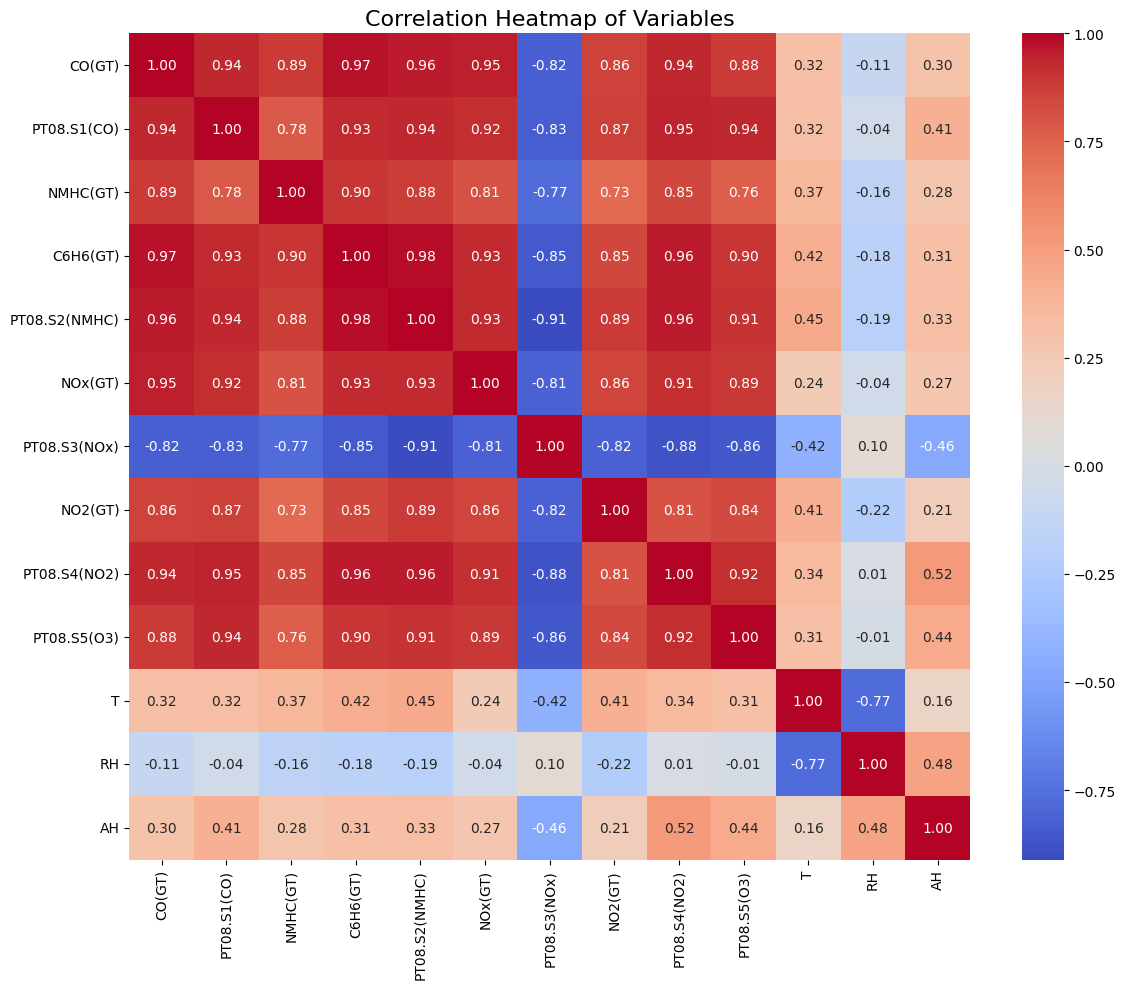

In [6]:
# Calculate the correlation matrix
correlation_matrix = scaled_data.corr()#data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Variables", fontsize=16)
plt.tight_layout()
plt.savefig("correlation_matrix_after_transformation.png")
plt.show()


Gamma Model

Gamma Model: Prior Check

In [7]:
# Define the target and predictor variables
target_variable = 'C6H6(GT)'
predictor_variables = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 
                    'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Subset the data to include only the target and predictor variablesa
# data = data[[target_variable] + predictor_variables].dropna()
scaled_data = scaled_data[[target_variable] + predictor_variables].dropna()

# Prepare predictors and target
X = scaled_data[predictor_variables]
y = scaled_data[target_variable]

# Ensure the target variable contains only positive values
if (y <= 0).any():
    print("Target variable contains non-positive values. Adjusting...")
    y += 0.001  # Add a small constant to ensure positivity

# Perform prior predictive checks
with pm.Model() as gamma_model_prior:
    # Priors for the coefficients
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Linear predictor
    mu = pm.math.exp(pm.math.dot(X.values, beta) + intercept)
    alpha = pm.HalfCauchy("alpha", beta=2)  # Shape parameter
    
    # Likelihood (without observed data for prior predictive checks)
    target = pm.Gamma("target", alpha=alpha, beta=alpha / mu)
    
    # Sample from the prior predictive distribution
    prior_predictive = pm.sample_prior_predictive()


Target variable contains non-positive values. Adjusting...


Sampling: [alpha, beta, intercept, target]


In [8]:
prior_predictive

Inference data with groups:
	> prior

In [9]:
prior_gamma_beta_shape = prior_predictive["prior"]["beta"].shape
prior_gamma_beta_shape

(1, 500, 12)

In [10]:
prior_gamma_beta_values = prior_predictive["prior"]["beta"].values.reshape(prior_gamma_beta_shape[1], prior_gamma_beta_shape[2])
prior_gamma_beta_values.shape

(500, 12)

In [11]:
prior_gamma_beta_values.shape

(500, 12)

In [12]:
prior_gamma_intercept = prior_predictive["prior"]["intercept"].values.flatten()
type(prior_gamma_intercept)

numpy.ndarray

In [13]:
prior_gamma_alpha = prior_predictive["prior"]["alpha"].values.flatten()
type(prior_gamma_alpha)

numpy.ndarray

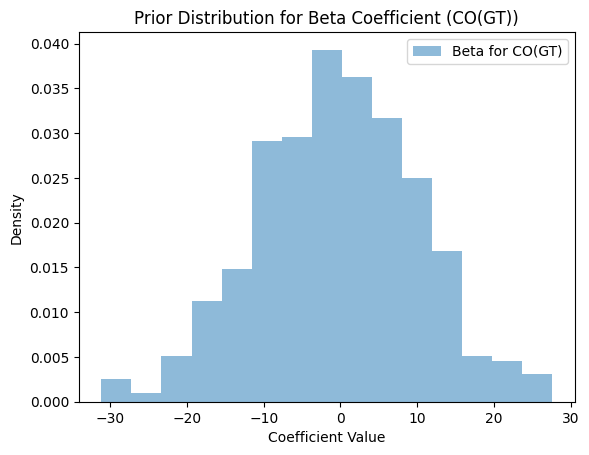

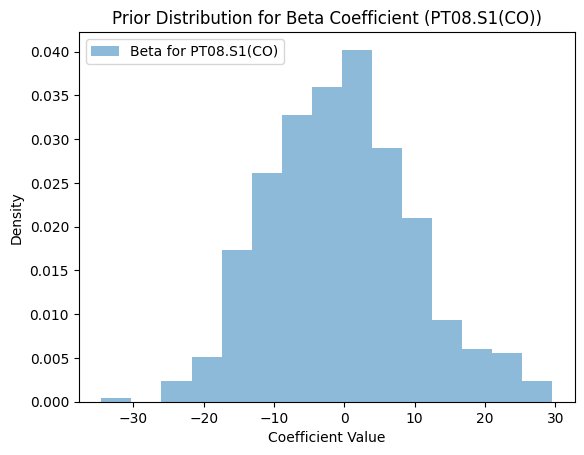

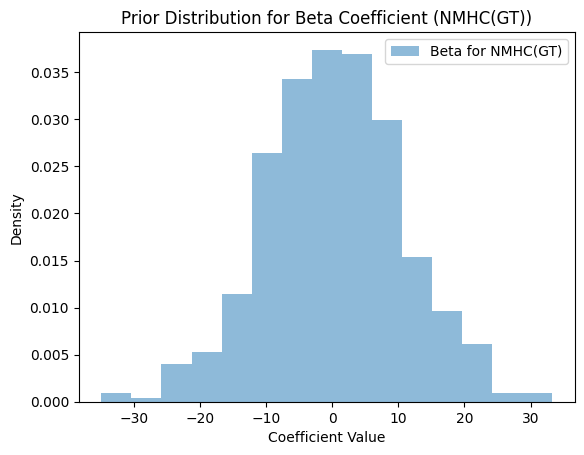

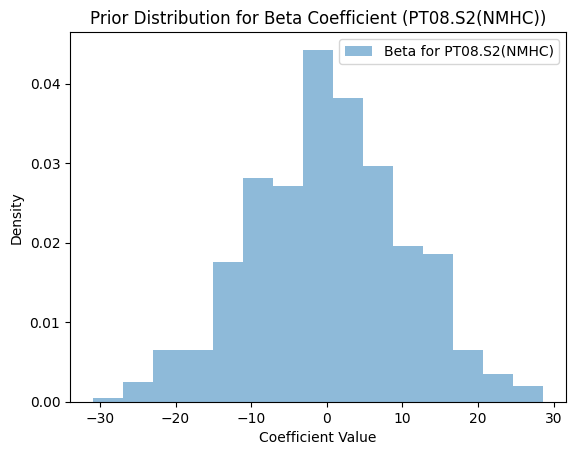

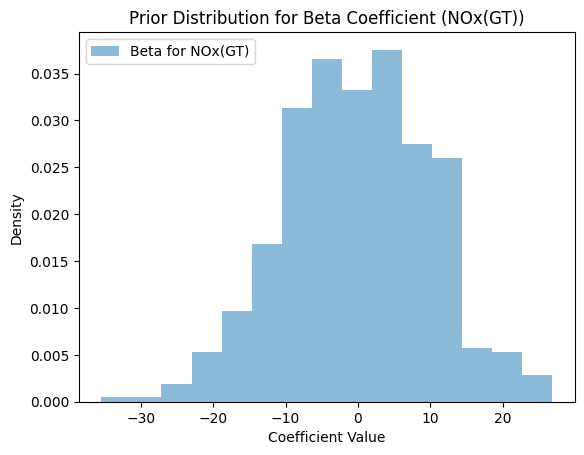

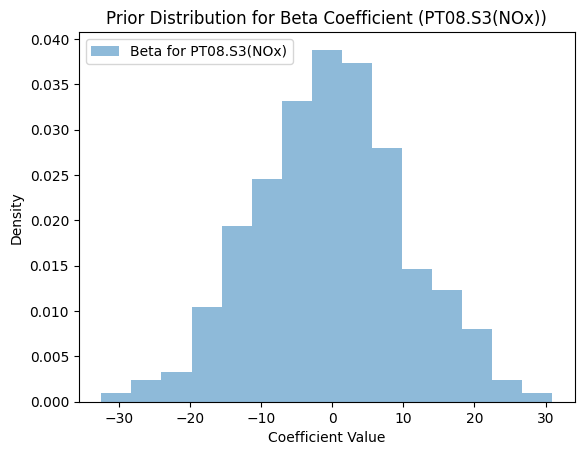

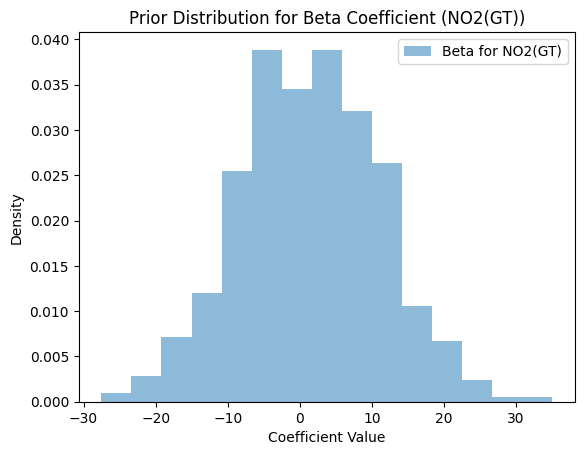

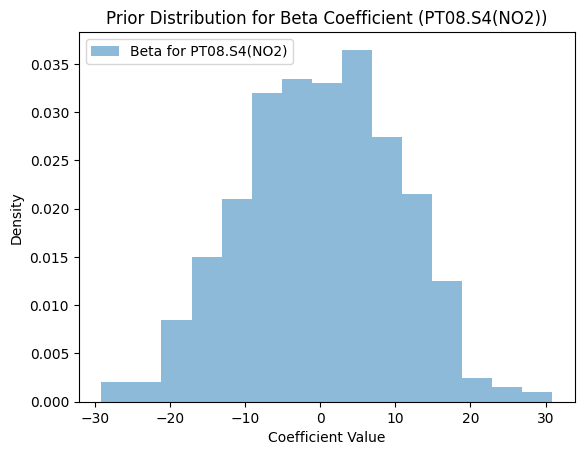

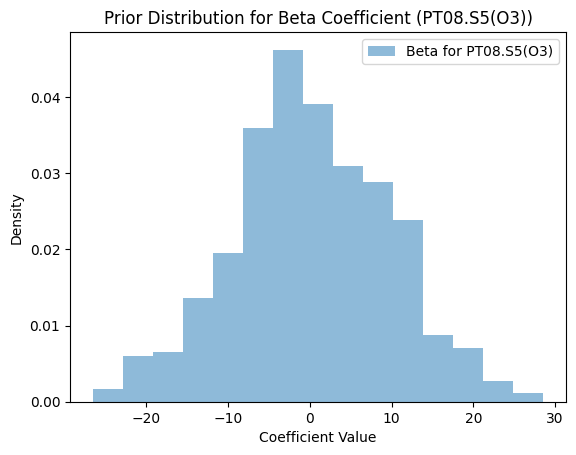

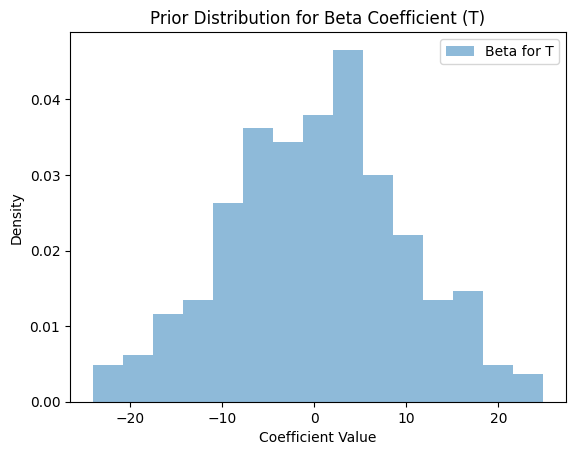

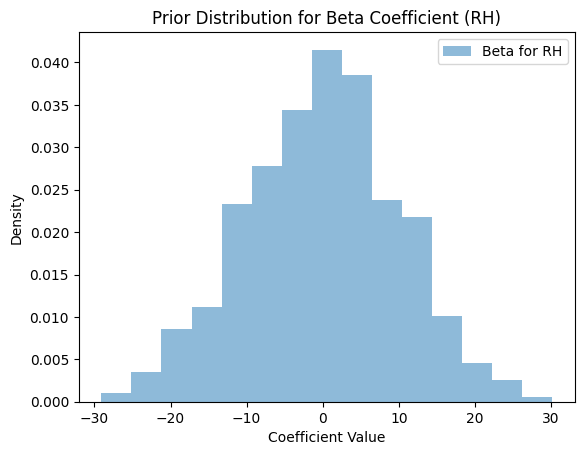

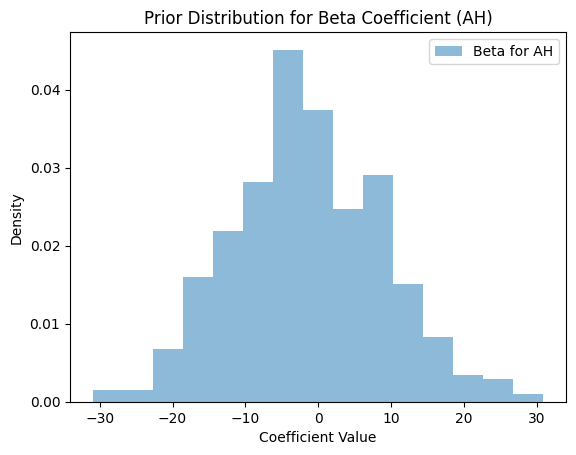

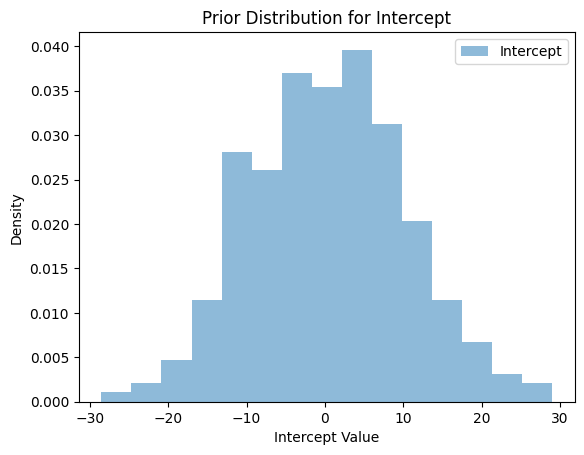

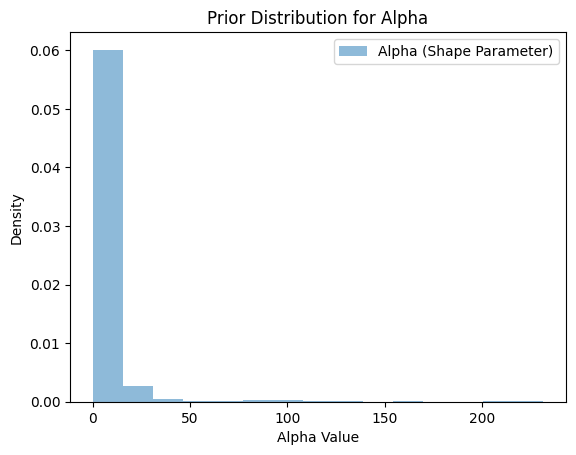

In [14]:
# Plot priors for coefficients (beta)
for i, predictor in enumerate(predictor_variables):
    # prior_predictive["prior"]["beta"]
    plt.hist(prior_gamma_beta_values[:, i], bins=15, density=True, alpha=0.5, label=f"Beta for {predictor}")
    plt.title(f"Prior Distribution for Beta Coefficient ({predictor})")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Plot prior for intercept
plt.hist(prior_gamma_intercept, bins=15, density=True, alpha=0.5, label="Intercept")
plt.title("Prior Distribution for Intercept")
plt.xlabel("Intercept Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# Plot prior for alpha
plt.hist(prior_gamma_alpha, bins=15, density=True, alpha=0.5, label="Alpha (Shape Parameter)")
plt.title("Prior Distribution for Alpha")
plt.xlabel("Alpha Value")
plt.ylabel("Density")
plt.legend()
plt.show()

Gamma Model: Posterior Check

In [15]:
# Define the target and predictor variables
target_variable = 'C6H6(GT)'
predictor_variables = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 
                    'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Subset the data to include only the target and predictor variablesa
# data = data[[target_variable] + predictor_variables].dropna()
scaled_data = scaled_data[[target_variable] + predictor_variables].dropna()

# Prepare predictors and target
X = scaled_data[predictor_variables]
y = scaled_data[target_variable]

# Ensure the target variable contains only positive values
if (y <= 0).any():
    print("Target variable contains non-positive values. Adjusting...")
    y += 0.001  # Add a small constant to ensure positivity

# Define the Bayesian Gamma Regression Model
with pm.Model() as gamma_model:
    # Priors for the coefficients
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Linear predictor
    mu = pm.math.exp(pm.math.dot(X.values, beta) + intercept)
    alpha = pm.HalfCauchy("alpha", beta=2)  # Shape parameter
    
    # Likelihood
    target = pm.Gamma("target", alpha=alpha, beta=alpha / mu, observed=y.values)
    
    # Initialize model with a custom start point
    initial_point = gamma_model.initial_point()
    initial_point["alpha"] = 1.0  # Positive initial value for alpha
    initial_point["beta"] = np.zeros(X.shape[1])  # Start with all coefficients at 0
    initial_point["intercept"] = np.log(np.mean(y))  # Approximate initial intercept
    
    # Sampling
    idata = pm.sample(500, tune=500, init="adapt_diag", start=initial_point)#, return_inferencedata=True

# Summarize the posterior
summary = idata.posterior#.to_dataframe()
# summary.head()


Initializing NUTS using adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta, intercept, alpha]


Output()

Sampling 3 chains for 500 tune and 500 draw iterations (1_500 + 1_500 draws total) took 56 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


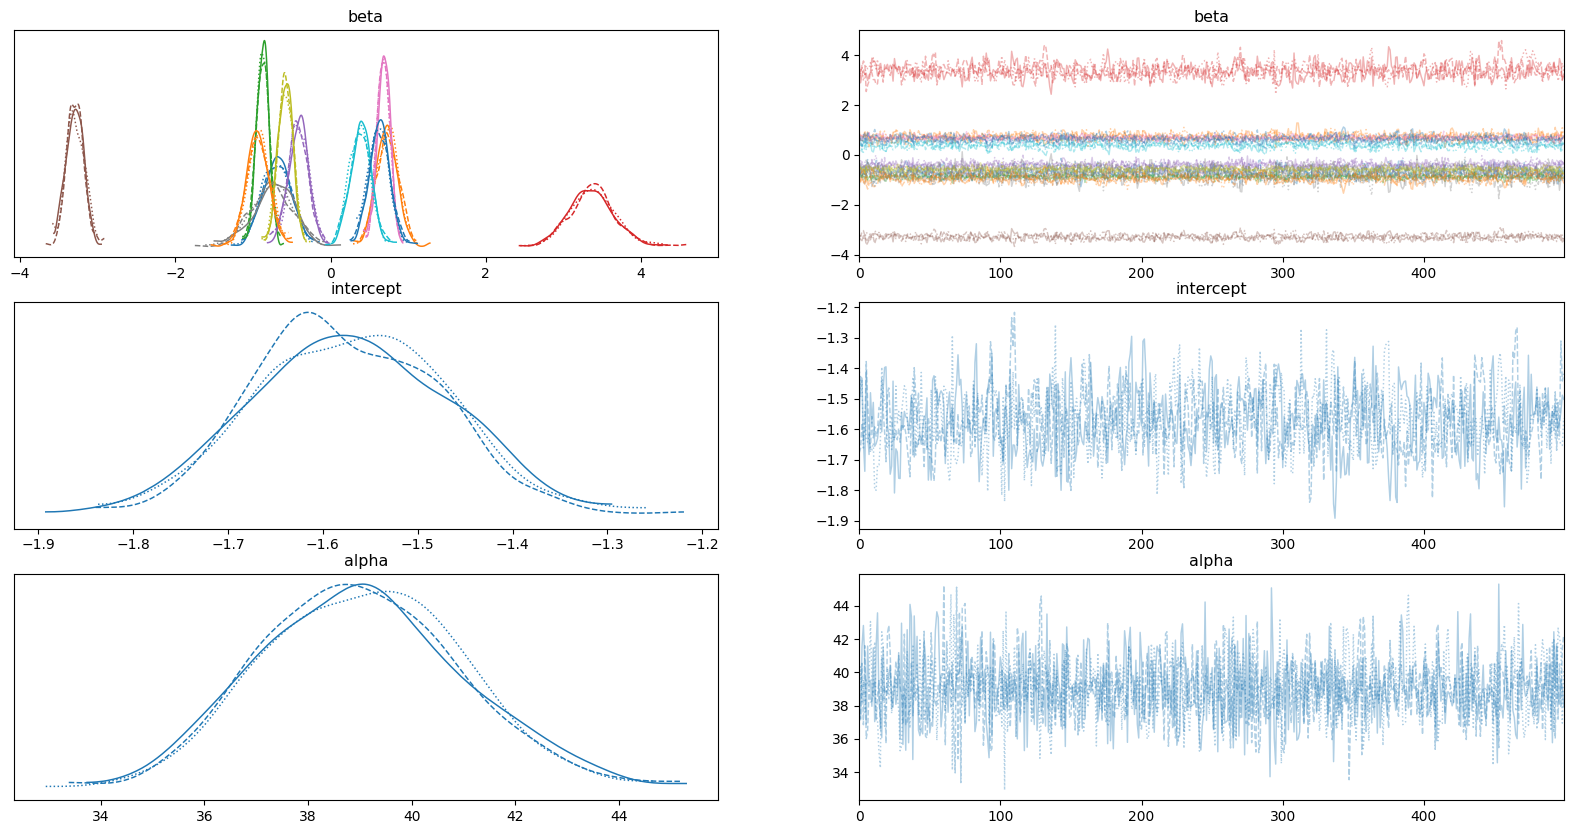

In [16]:
# Save and display posterior diagnostics
# posterior_summary = az.summary(summary)
az.plot_trace(summary, figsize=(20, 10), compact=True) #, var_names=scaled_data.columns
# plt.savefig("traceplot_beta_intercept_alpha.png")
plt.show()

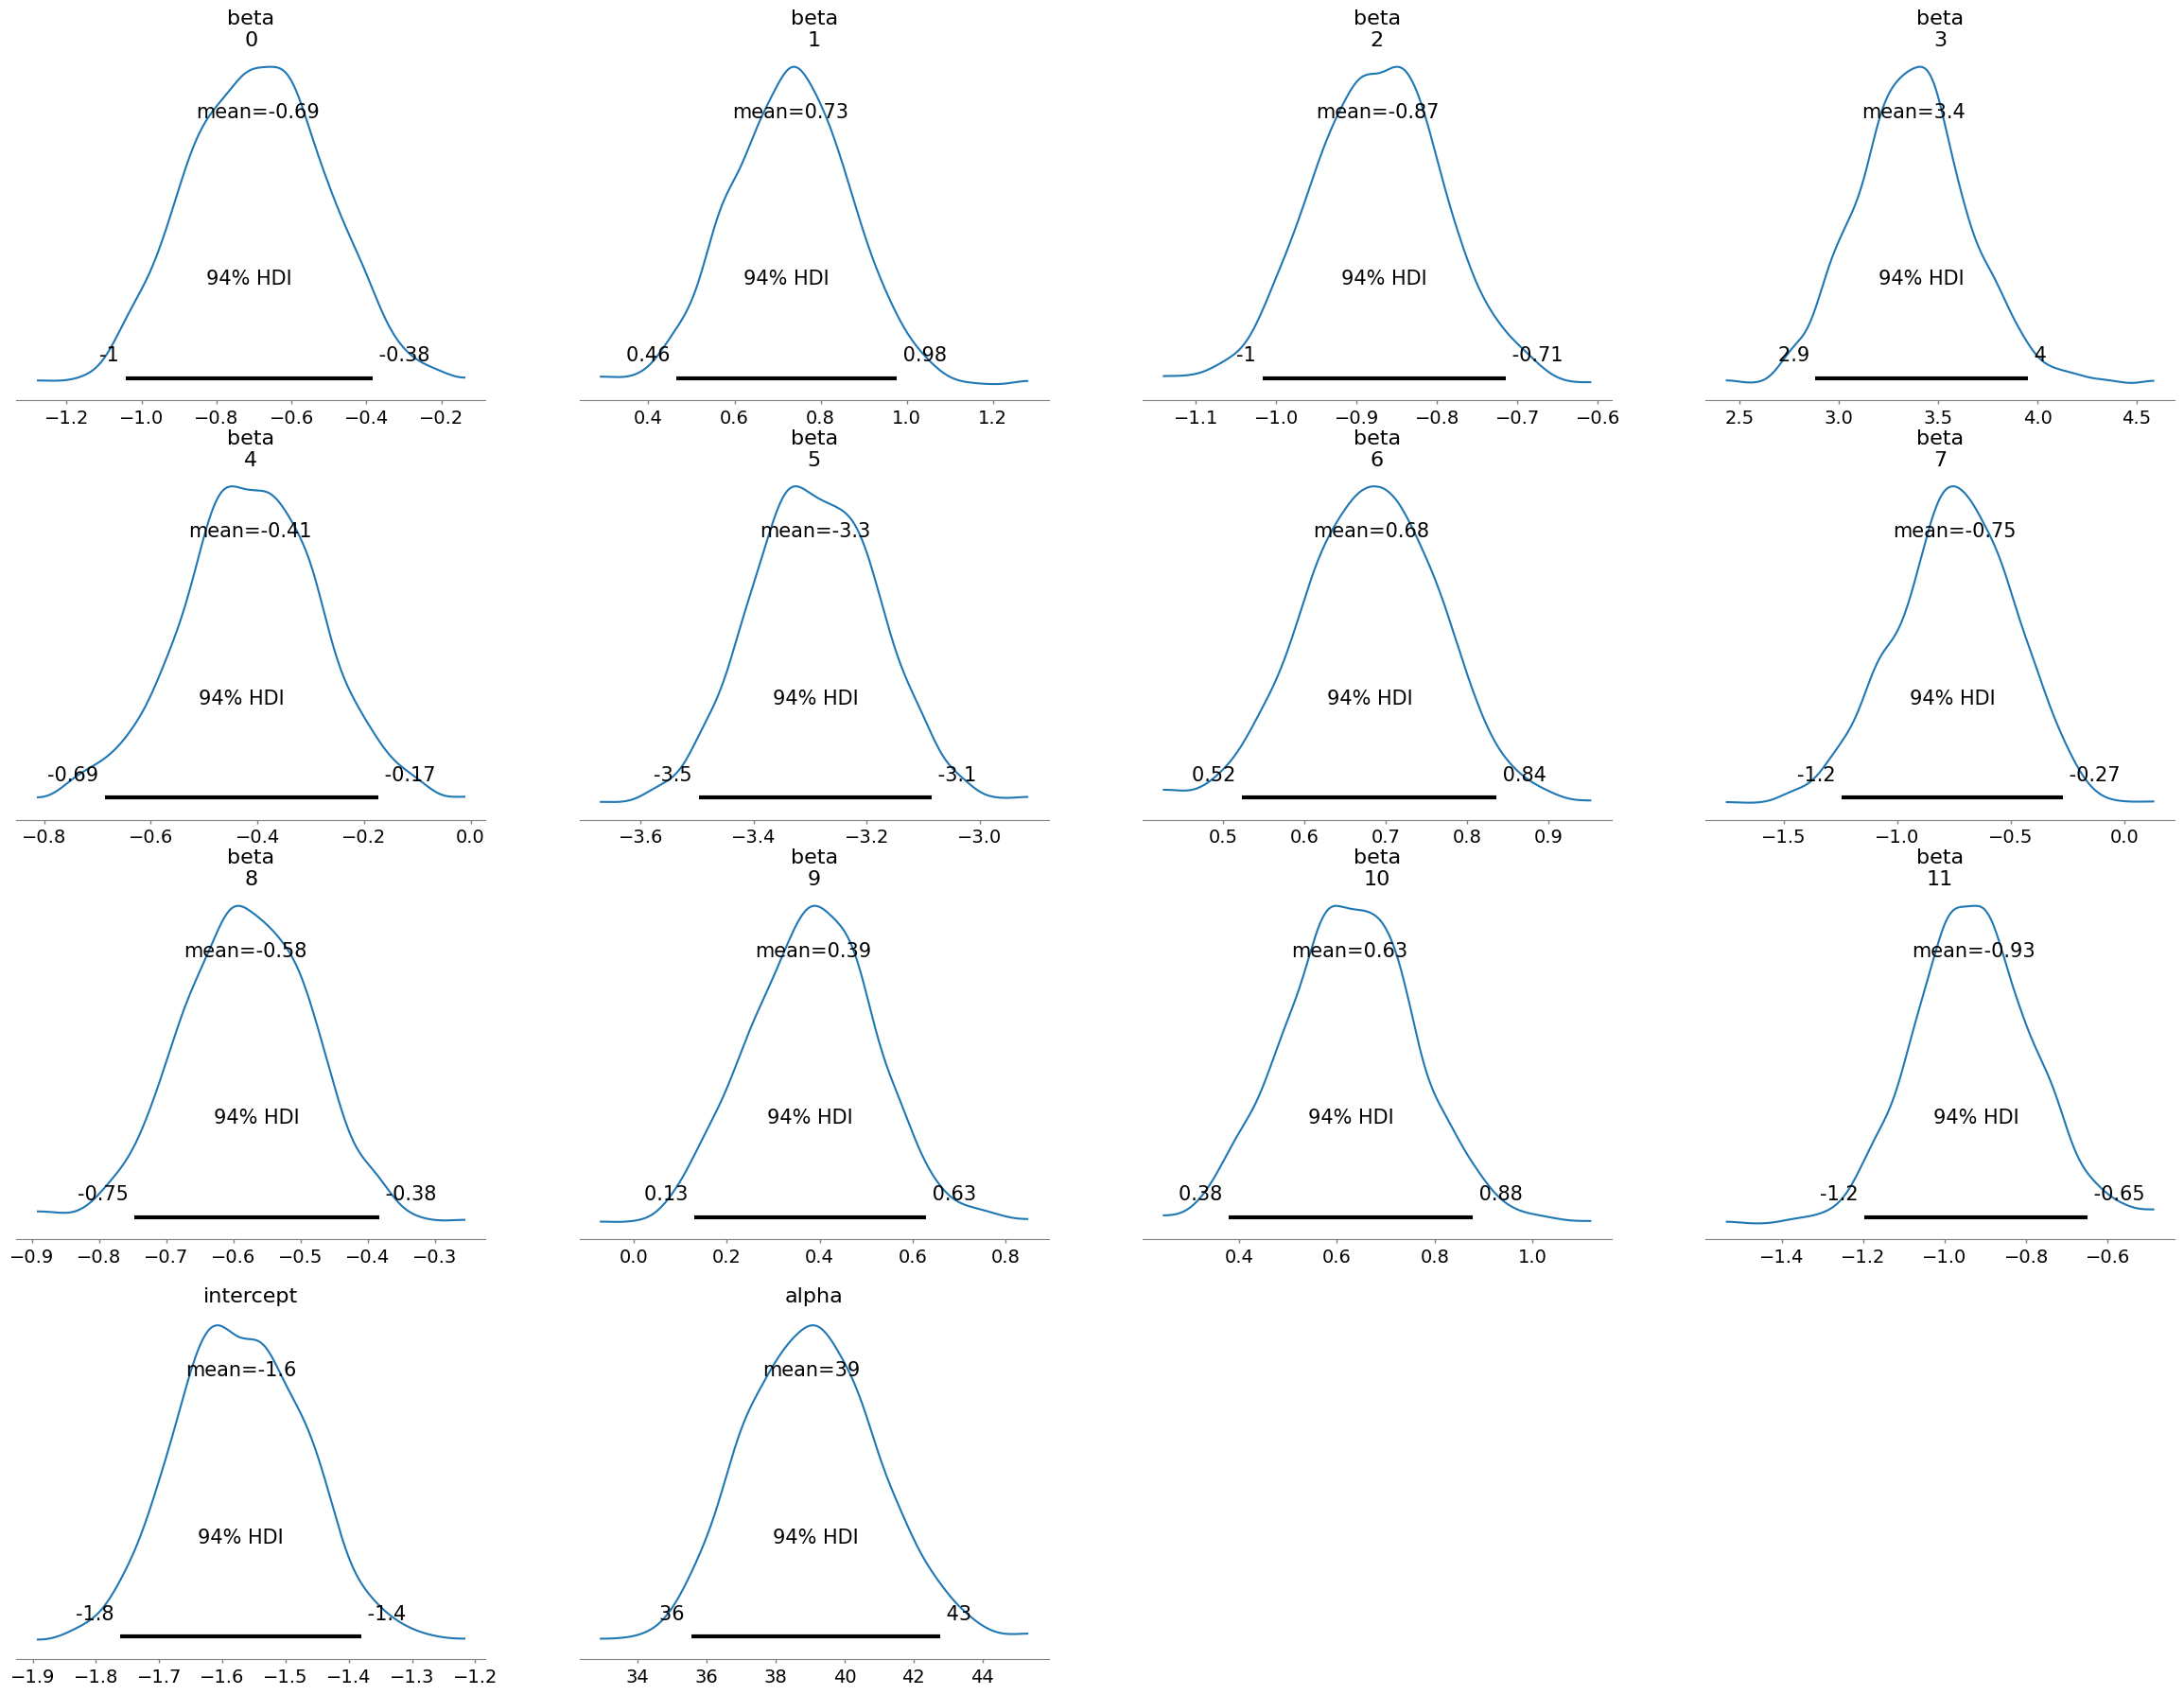

In [17]:
az.plot_posterior(summary)
# plt.savefig("posterior_beta_intercept_alpha.png")
plt.show()

# Display the posterior summary
# posterior_summary.to_csv('/mnt/data/posterior_summary.csv')
# posterior_summary

In [18]:
# Extract posterior samples for beta
gamma_beta_posterior = idata.posterior["beta"]
print(gamma_beta_posterior)

<xarray.DataArray 'beta' (chain: 3, draw: 500, beta_dim_0: 12)> Size: 144kB
array([[[-0.56849253,  0.72736819, -0.91122473, ...,  0.46598476,
          0.74147007, -0.90431728],
        [-0.70263783,  0.7852033 , -0.79830256, ...,  0.38893388,
          0.57758681, -1.09023921],
        [-0.47635076,  0.76336041, -0.9110585 , ...,  0.34288897,
          0.56757527, -0.93978973],
        ...,
        [-0.83624709,  0.92088127, -0.81261228, ...,  0.20418571,
          0.51922566, -0.86484474],
        [-0.64229558,  0.6325306 , -0.94036985, ...,  0.51286745,
          0.68807362, -0.98751541],
        [-0.60115724,  0.69115093, -0.92986889, ...,  0.45347647,
          0.74038637, -1.11792276]],

       [[-0.5623174 ,  0.84748651, -0.8849259 , ...,  0.18506579,
          0.46715398, -0.77107175],
        [-0.80502465,  0.63300873, -0.88043965, ...,  0.1526272 ,
          0.39487283, -0.7311663 ],
        [-0.83977877,  0.72853175, -0.80250042, ...,  0.1551641 ,
          0.37553525, -0.66

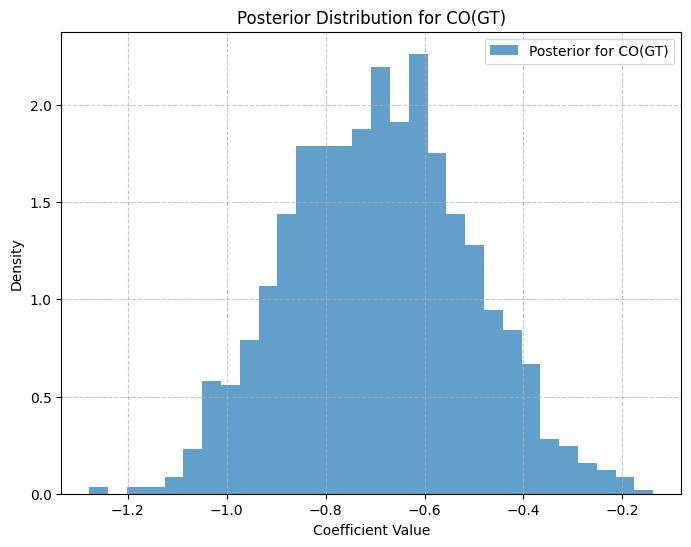

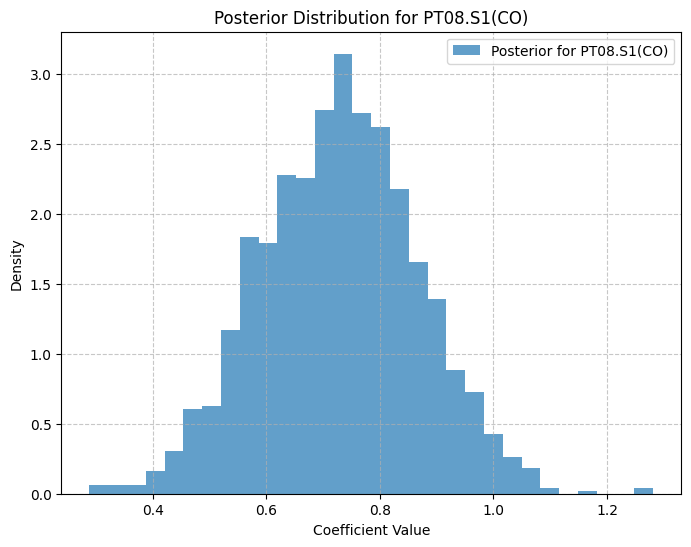

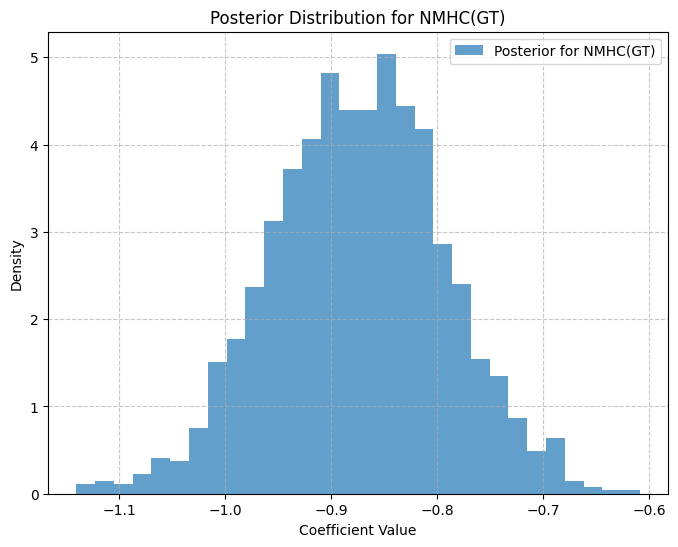

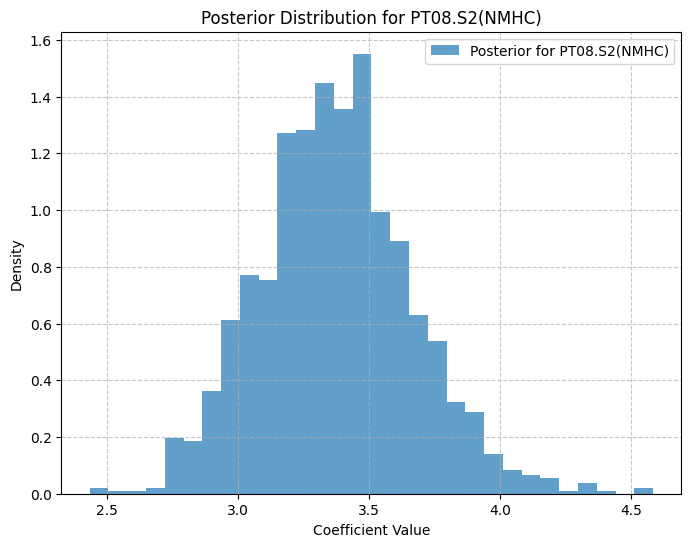

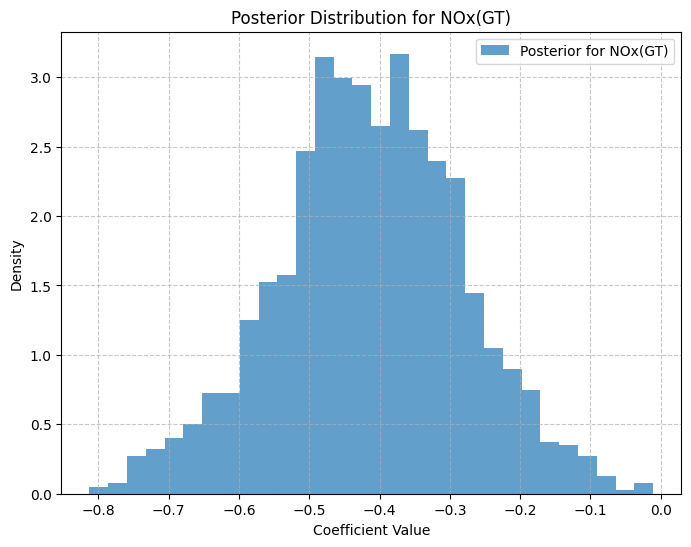

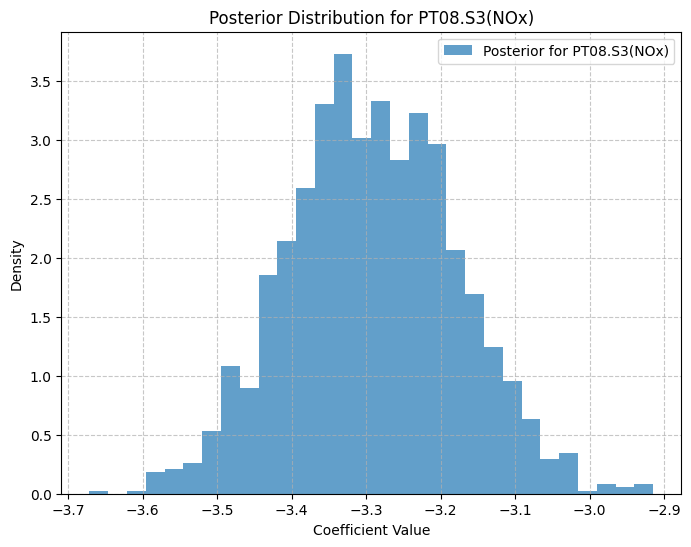

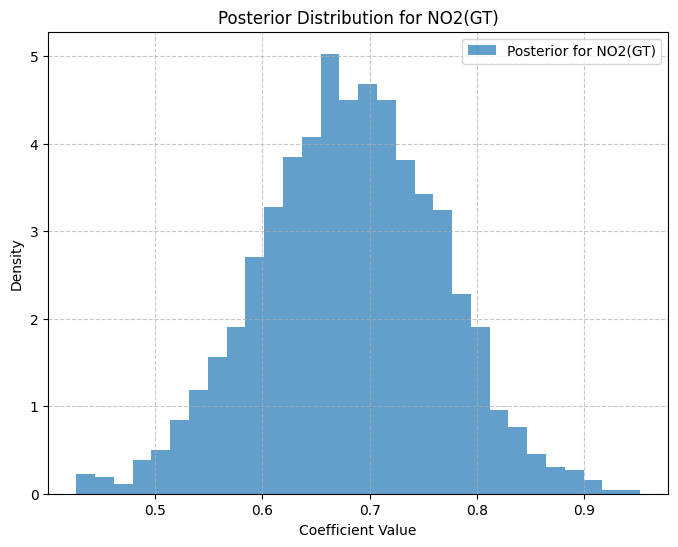

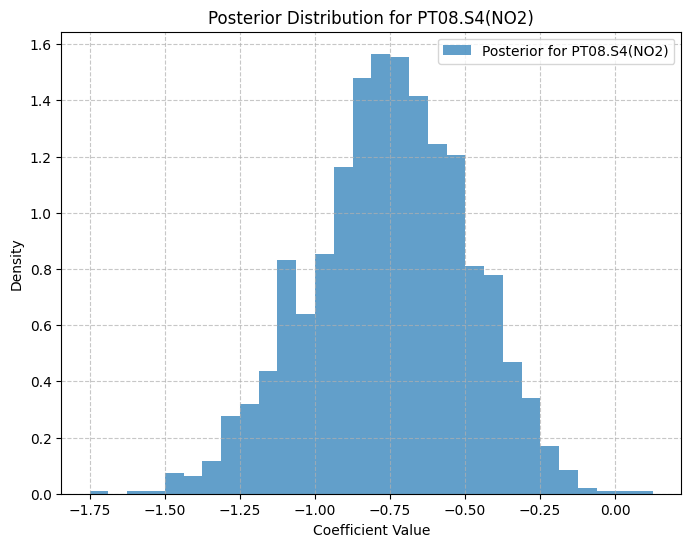

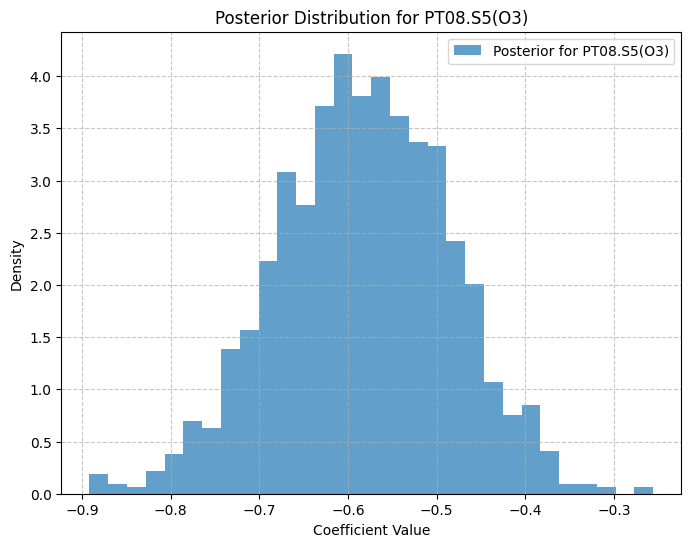

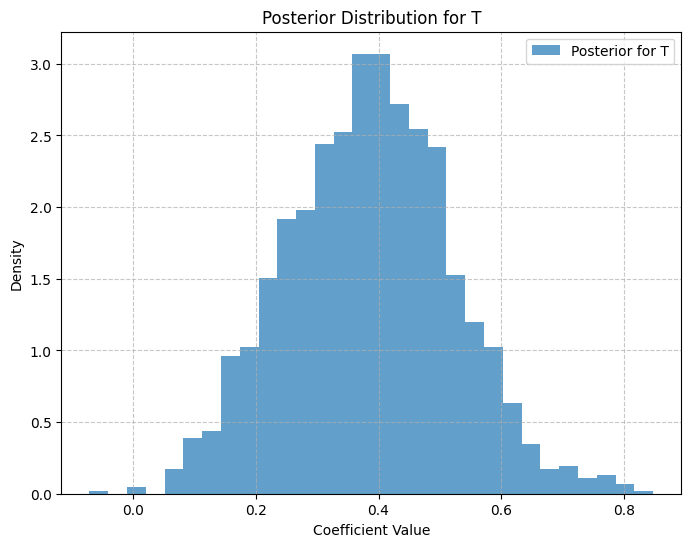

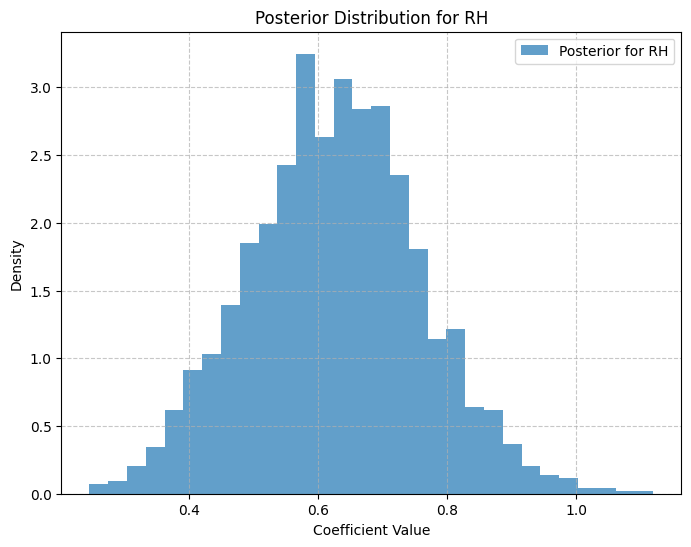

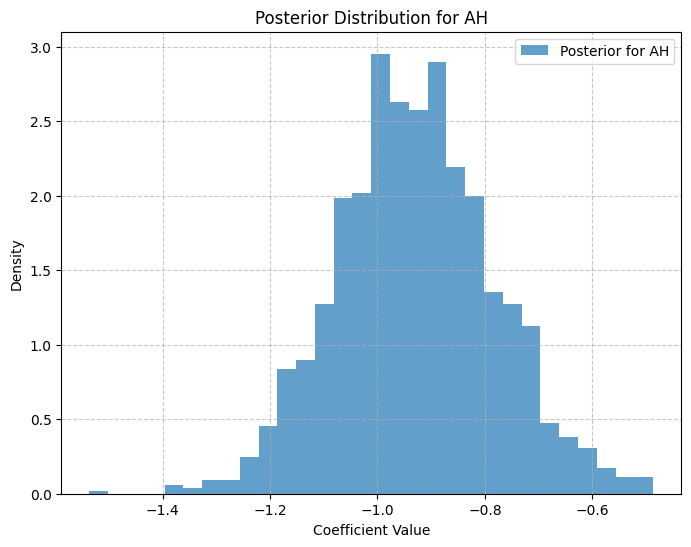

In [19]:
# Iterate through predictors and plot their posterior distributions
for i, predictor in enumerate(predictor_variables):
    # Extract posterior samples for the i-th predictor
    predictor_posterior = gamma_beta_posterior.sel(beta_dim_0=i).values.flatten()  # Convert to NumPy array

    # Plot the posterior distribution
    plt.figure(figsize=(8, 6))
    plt.hist(predictor_posterior, bins=30, density=True, alpha=0.7, label=f"Posterior for {predictor}")
    plt.title(f"Posterior Distribution for {predictor}")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()


In [20]:
# Summarize the posterior
# 95% credible interval
posterior_summary = az.summary(idata, var_names=["beta"], hdi_prob=0.95)
print(posterior_summary)

           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]  -0.691  0.182    -1.042     -0.360      0.005    0.004    1108.0   
beta[1]   0.729  0.139     0.451      0.986      0.004    0.003    1388.0   
beta[2]  -0.874  0.082    -1.029     -0.714      0.002    0.002    1179.0   
beta[3]   3.374  0.290     2.802      3.932      0.011    0.008     767.0   
beta[4]  -0.414  0.132    -0.700     -0.166      0.003    0.003    1451.0   
beta[5]  -3.291  0.113    -3.504     -3.076      0.004    0.003     804.0   
beta[6]   0.682  0.084     0.519      0.845      0.002    0.002    1336.0   
beta[7]  -0.750  0.263    -1.280     -0.271      0.008    0.006    1071.0   
beta[8]  -0.583  0.097    -0.761     -0.382      0.002    0.002    1762.0   
beta[9]   0.386  0.135     0.109      0.628      0.005    0.004     690.0   
beta[10]  0.626  0.134     0.365      0.880      0.005    0.004     680.0   
beta[11] -0.929  0.146    -1.205     -0.636      0.006    0.004     640.0   

In [21]:
# summary for posterior of gamma regression
posterior_summary

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]  -0.691  0.182    -1.042     -0.360      0.005    0.004    1108.0   
beta[1]   0.729  0.139     0.451      0.986      0.004    0.003    1388.0   
beta[2]  -0.874  0.082    -1.029     -0.714      0.002    0.002    1179.0   
beta[3]   3.374  0.290     2.802      3.932      0.011    0.008     767.0   
beta[4]  -0.414  0.132    -0.700     -0.166      0.003    0.003    1451.0   
beta[5]  -3.291  0.113    -3.504     -3.076      0.004    0.003     804.0   
beta[6]   0.682  0.084     0.519      0.845      0.002    0.002    1336.0   
beta[7]  -0.750  0.263    -1.280     -0.271      0.008    0.006    1071.0   
beta[8]  -0.583  0.097    -0.761     -0.382      0.002    0.002    1762.0   
beta[9]   0.386  0.135     0.109      0.628      0.005    0.004     690.0   
beta[10]  0.626  0.134     0.365      0.880      0.005    0.004     680.0   
beta[11] -0.929  0.146    -1.205     -0.636      0.006    0.004     640.0   

          ess_tail  r_hat  
beta[0]     1253.0    1.0  
beta[1]     1169.0    1.0  
beta[2]     1047.0    1.0  
beta[3]      698.0    1.0  
beta[4]      846.0    1.0  
beta[5]      849.0    1.0  
beta[6]     1076.0    1.0  
beta[7]      961.0    1.0  
beta[8]     1253.0    1.0  
beta[9]      774.0    1.0  
beta[10]     799.0    1.0  
beta[11]     786.0    1.0

In [22]:
prior_gamma_beta_values.shape

(500, 12)

In [23]:
idata.posterior["beta"].values.shape

(3, 500, 12)

In [24]:
len(gamma_beta_posterior)

3

In [25]:
posterior_gamma_beta_values = []
for i, _ in enumerate(range(len(gamma_beta_posterior))):
    posterior_gamma_beta_values.append(gamma_beta_posterior[i].shape)
    # = idata.posterior["beta"].values.flatten() #.sel(beta_dim_0=i)
# posterior_gamma_beta_values.shape

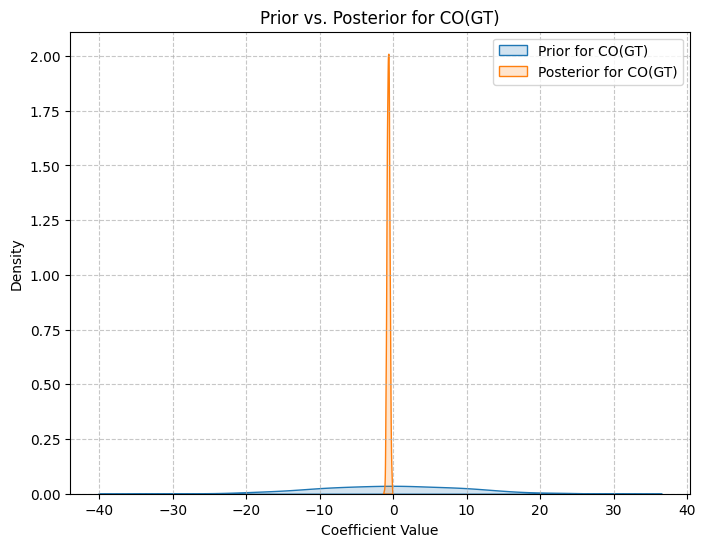

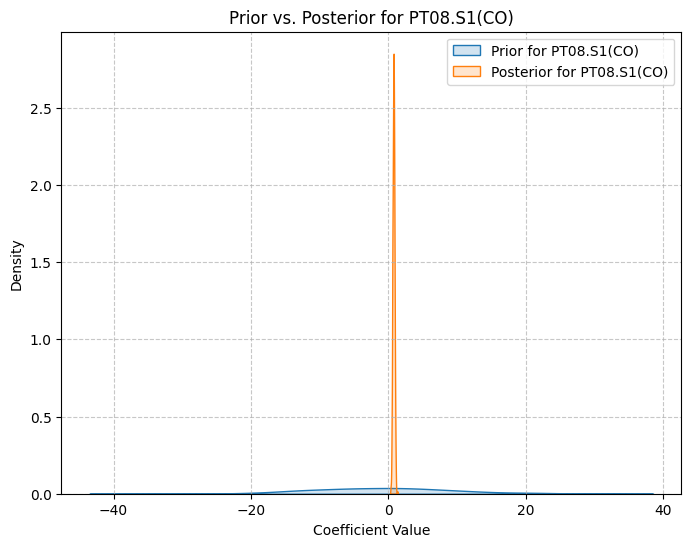

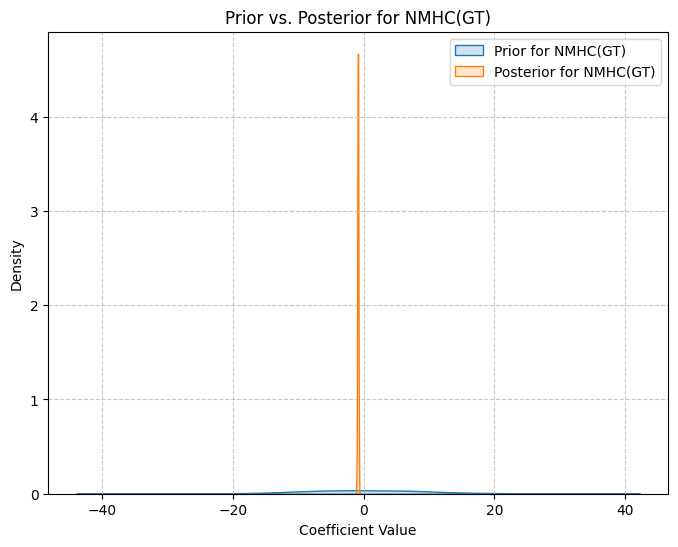

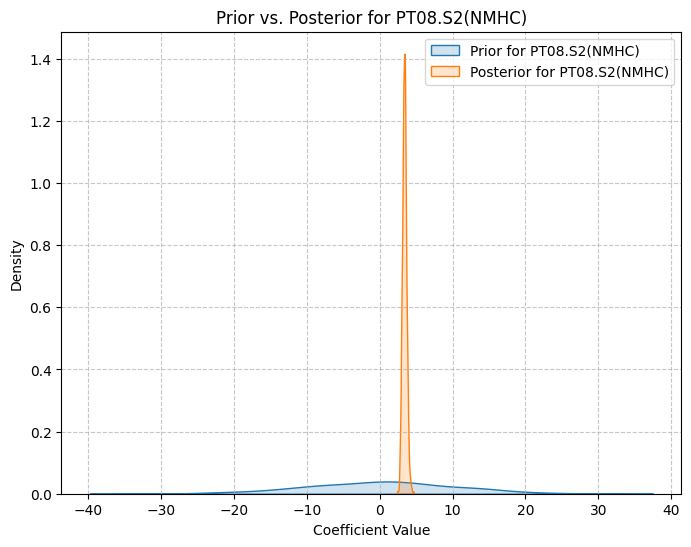

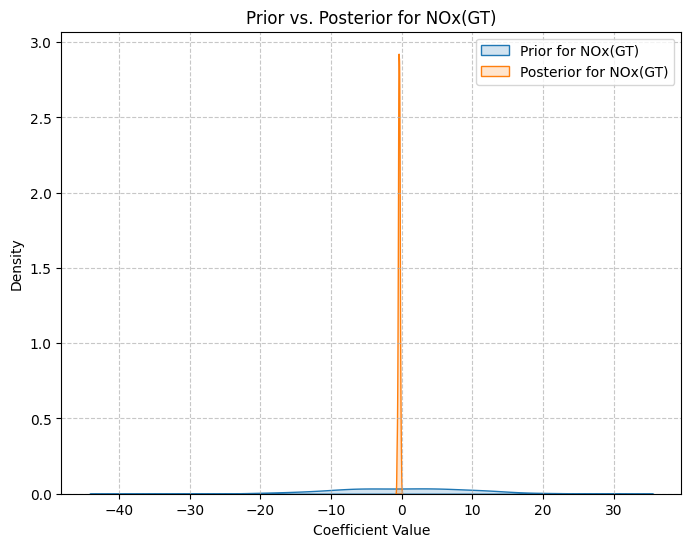

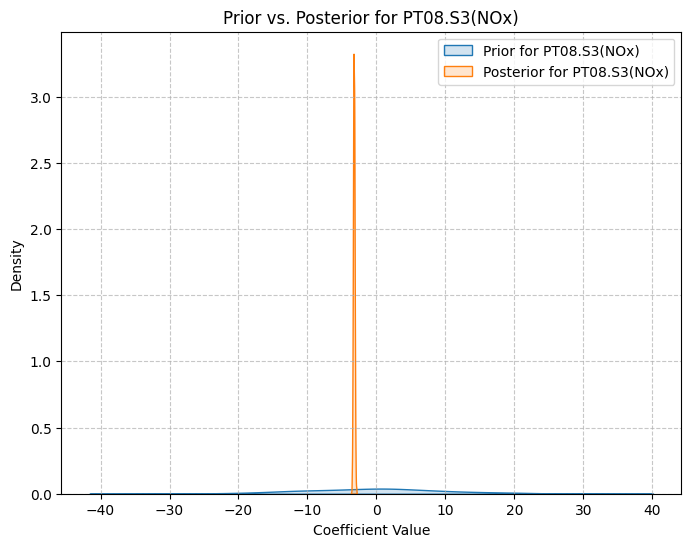

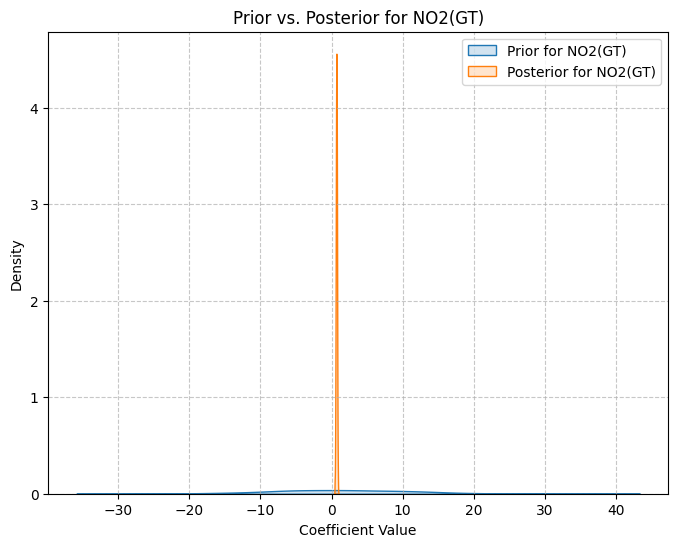

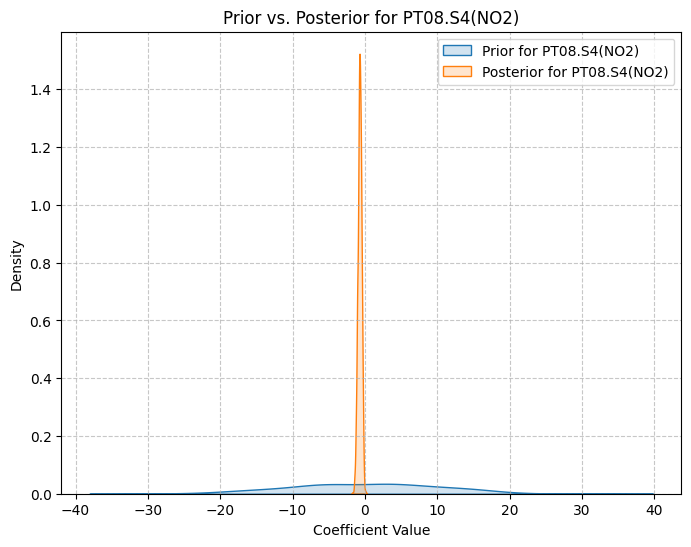

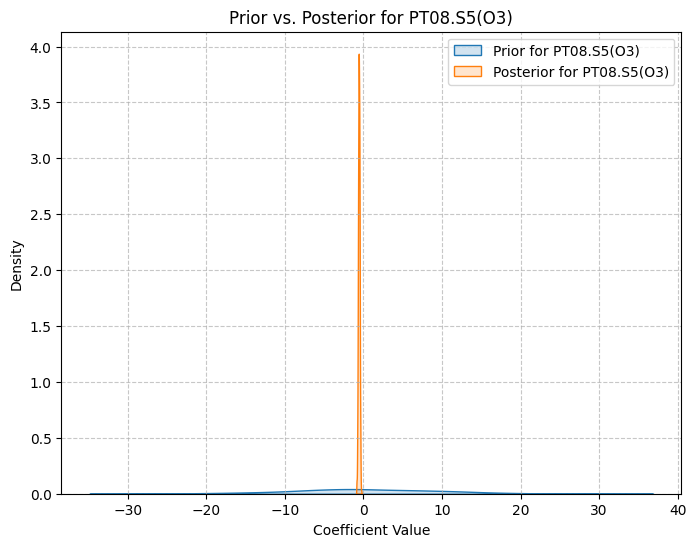

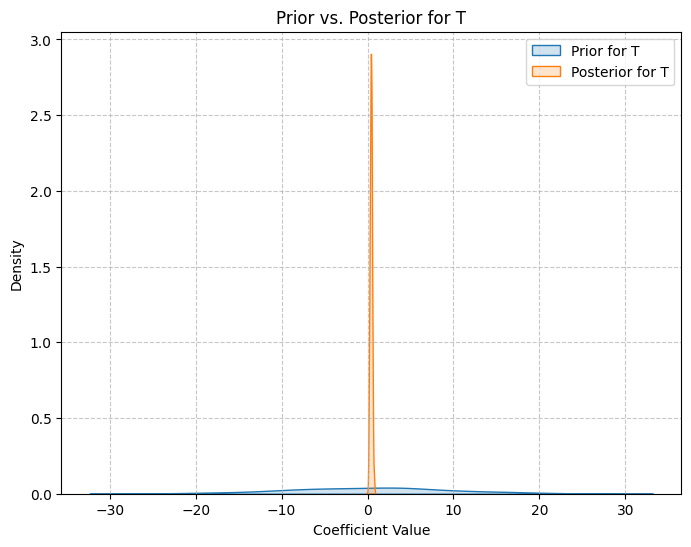

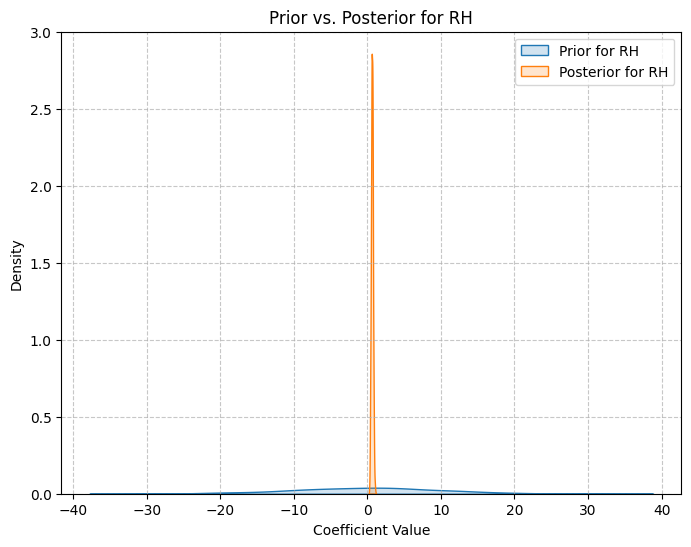

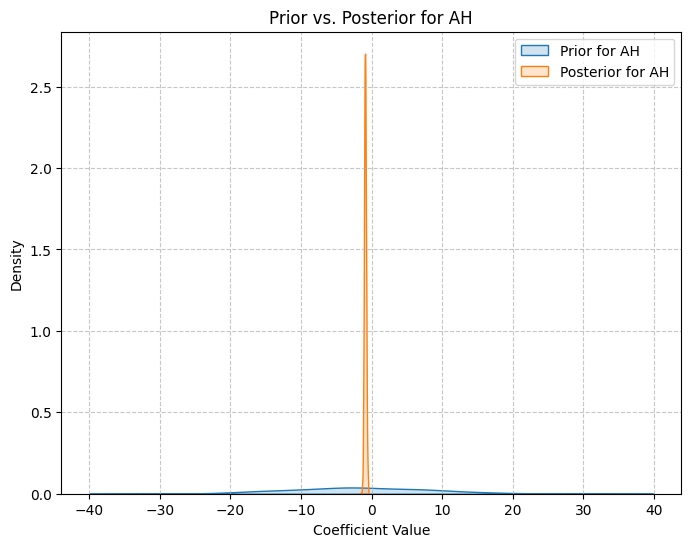

In [26]:
for i, predictor_name in enumerate(predictor_variables):
    # for posterior_gamma_beta in posterior_gamma_beta_values:
    # Extract prior and posterior for each predictor
    prior_samples = prior_gamma_beta_values[:, i]
    posterior_samples = idata.posterior["beta"].sel(beta_dim_0=i).values.flatten()
    # posterior_samples = idata.posterior["beta"].values.reshape((-1, idata.posterior["beta"].values.shape[1], idata.posterior["beta"].values.shape[2]))
    #idata.posterior["beta"].sel(beta_dim_0=i)#.values.flatten() #posterior_gamma_beta_values#
    # gamma_beta_posterior.sel(beta_dim_0=i).values.flatten()

    # Plot prior vs. posterior
    plt.figure(figsize=(8, 6))#(8, 6)
    # plt.hist(prior_samples, bins=100, density=True, alpha=0.5, label=f"Prior for {predictor_name}")
    # plt.hist(posterior_samples, bins=100, density=True, alpha=0.5, label=f"Posterior for {predictor_name}")
    sns.kdeplot(prior_samples, fill=True, alpha=0.2, label=f"Prior for {predictor_name}")
    sns.kdeplot(posterior_samples, fill=True, alpha=0.2, label=f"Posterior for {predictor_name}")
    plt.title(f"Prior vs. Posterior for {predictor_name}")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()


Gamma Model Evaluation

In [27]:
with gamma_model:
    # log_likelihood_gamma = 
    pm.compute_log_likelihood(idata)

Output()

In [28]:
# Compute WAIC and LOO for Model Comparison
try:
    # Compute WAIC
    waic = az.waic(idata)
    print(f"WAIC: {waic}")

    # Compute LOO
    gamma_loo = az.loo(idata)
    print(f"LOO: {loo}")

except Exception as e:
    print("Error in computing WAIC/LOO:", str(e))

WAIC: Computed from 1500 posterior samples and 827 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  1697.26    64.96
p_waic       27.47        -

There has been a warning during the calculation. Please check the results.
Error in computing WAIC/LOO: name 'loo' is not defined


Student t-model

Student t-model: Prior

In [29]:
# Define the Student-t model structure for prior sampling
with pm.Model() as student_t_prior_model:
    # Priors for coefficients, intercept, and degrees of freedom
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])  # Coefficients for predictors
    intercept = pm.Normal("intercept", mu=0, sigma=10)  # Intercept
    nu = pm.Exponential("nu", 1.0)  # Degrees of freedom (Student-t)

    # Linear predictor
    mu = pm.math.dot(X, beta) + intercept

    # Likelihood (without observed data for prior predictive checks)
    target = pm.StudentT("target", nu=nu, mu=mu, sigma=1.0)

    # Sample from the prior predictive distribution
    student_prior_predictive = pm.sample_prior_predictive()


Sampling: [beta, intercept, nu, target]


In [30]:
student_prior_beta_shape = student_prior_predictive["prior"]["beta"].shape
student_prior_beta_shape

(1, 500, 12)

In [31]:
student_prior_beta_values = student_prior_predictive["prior"]["beta"].values.reshape(
    student_prior_beta_shape[1], student_prior_beta_shape[2])
student_prior_beta_values.shape

(500, 12)

In [32]:
student_prior_intercept = student_prior_predictive["prior"]["intercept"].values.flatten()

In [33]:
student_prior_nu = student_prior_predictive["prior"]["nu"].values.flatten()
type(student_prior_nu)

numpy.ndarray

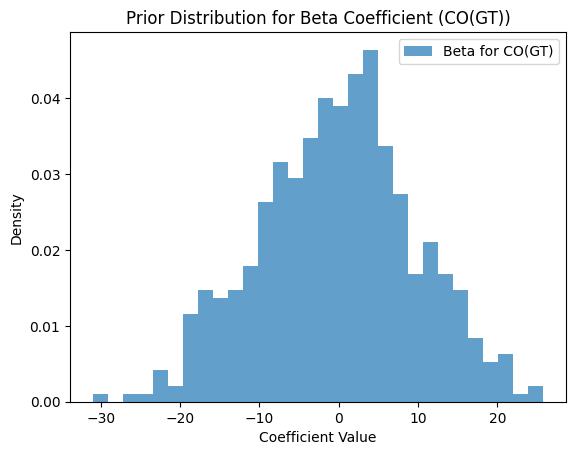

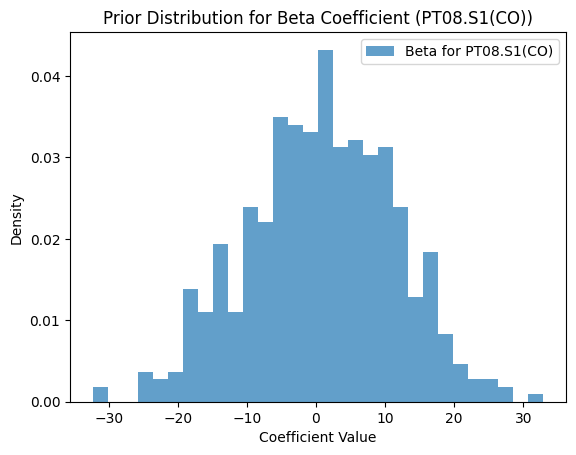

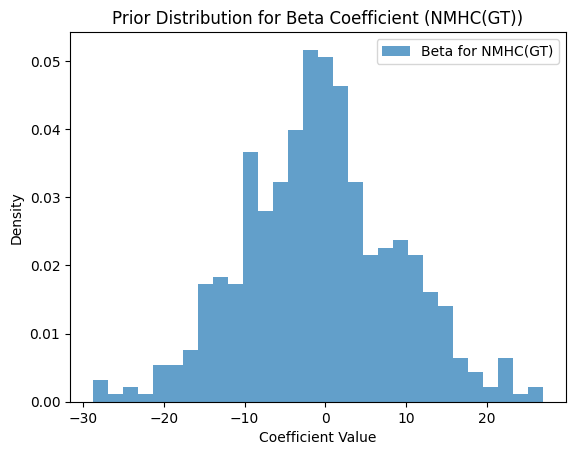

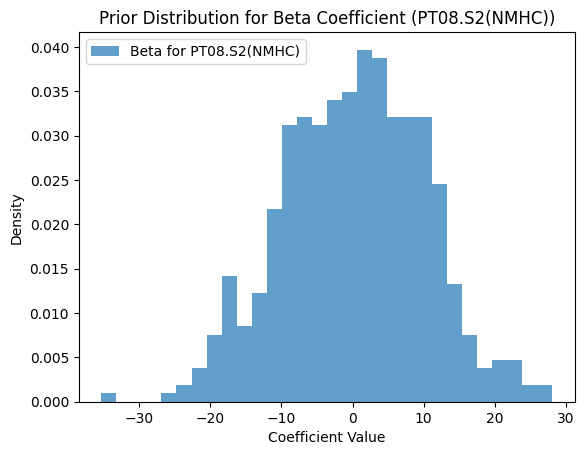

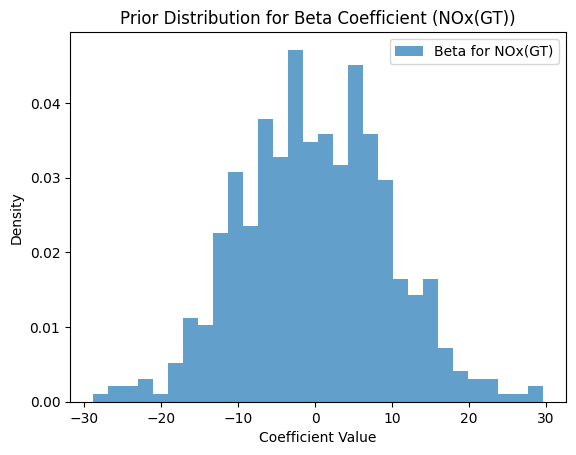

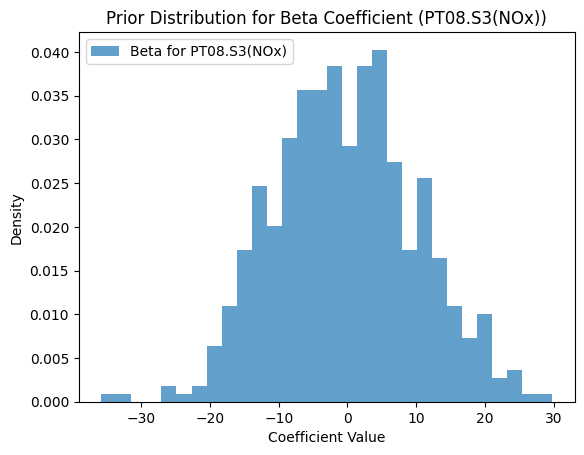

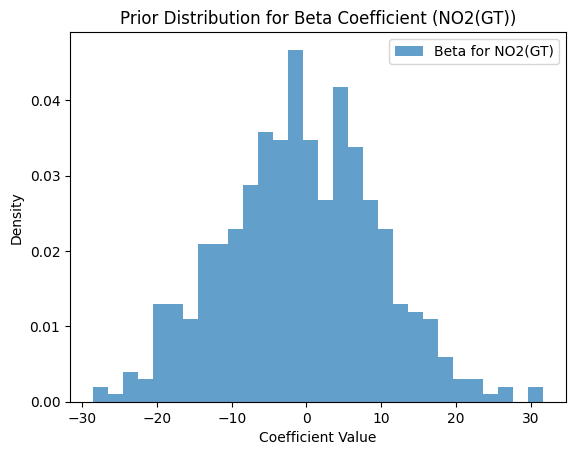

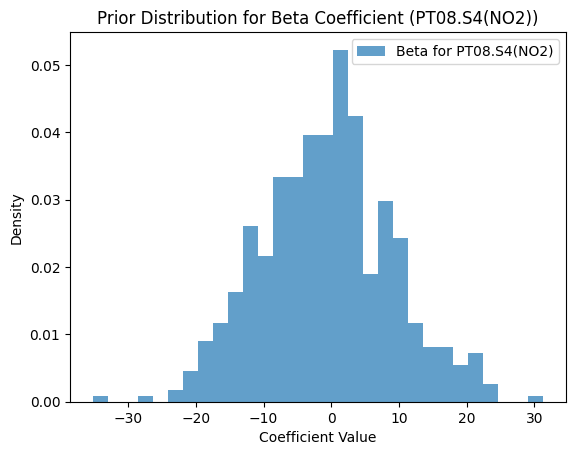

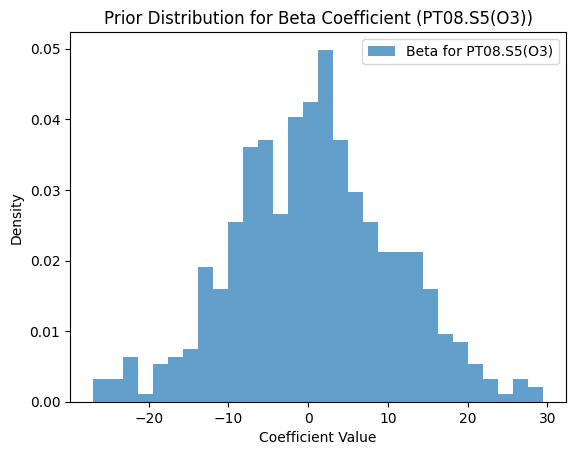

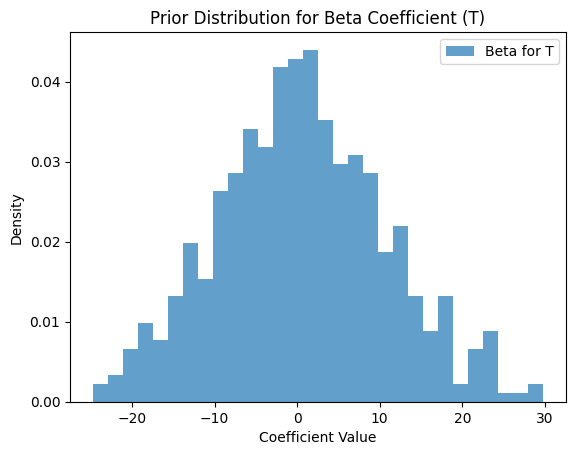

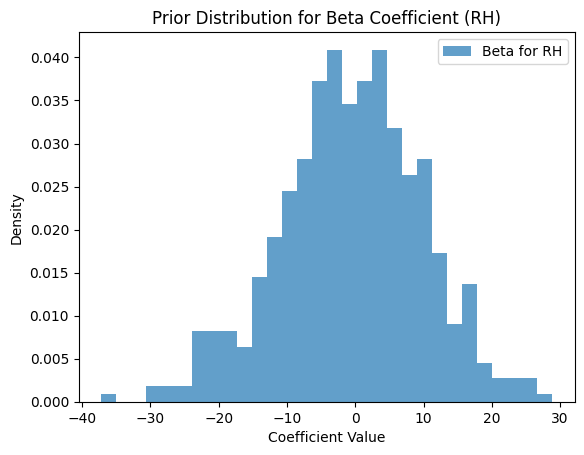

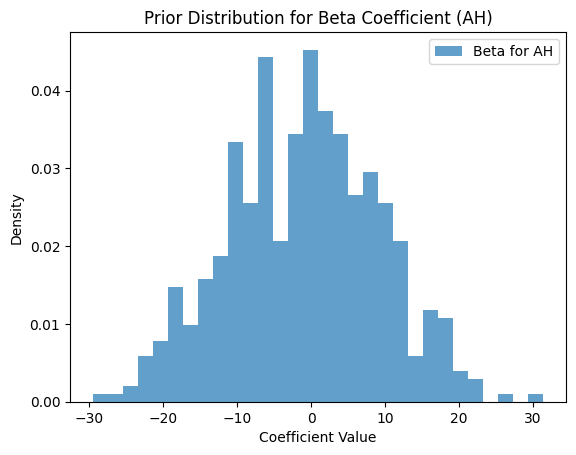

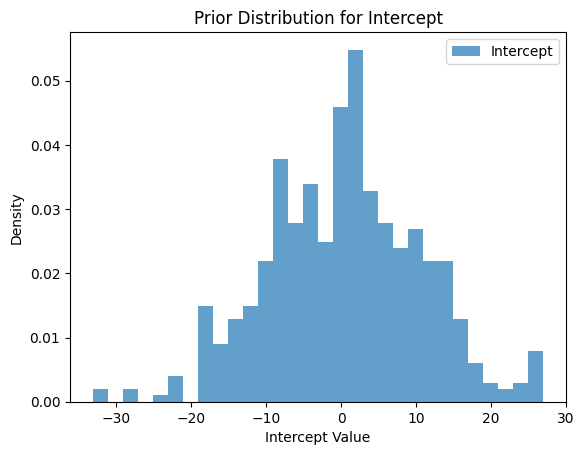

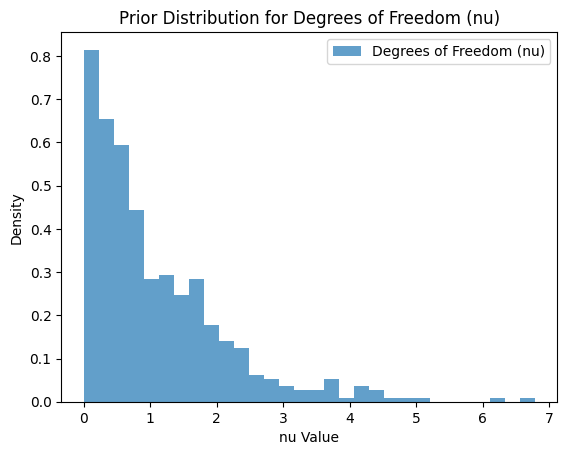

In [37]:
predictor_columns = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 
                    'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
# Plot prior for coefficients (beta)
for i, predictor in enumerate(predictor_columns):
    plt.hist(student_prior_beta_values[:, i], bins=30, density=True, alpha=0.7, label=f"Beta for {predictor}")
    plt.title(f"Prior Distribution for Beta Coefficient ({predictor})")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Plot prior for intercept
plt.hist(student_prior_intercept, bins=30, density=True, alpha=0.7, label="Intercept")
plt.title("Prior Distribution for Intercept")
plt.xlabel("Intercept Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# Plot prior for degrees of freedom (nu)
plt.hist(student_prior_nu, bins=30, density=True, alpha=0.7, label="Degrees of Freedom (nu)")
plt.title("Prior Distribution for Degrees of Freedom (nu)")
plt.xlabel("nu Value")
plt.ylabel("Density")
plt.legend()
plt.show()


In [38]:
with pm.Model() as student_t_model:
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    nu = pm.Exponential("nu", 1.0)  # Degrees of freedom
    mu = pm.math.dot(X, beta) + intercept
    target = pm.StudentT("target", nu=nu, mu=mu, sigma=1.0, observed=y)
    trace_student_t = pm.sample(500, tune=500, return_inferencedata=True)
    student_posterior_predictive = pm.sample_posterior_predictive(trace_student_t, model=student_t_model)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta, intercept, nu]


Output()

Sampling 3 chains for 500 tune and 500 draw iterations (1_500 + 1_500 draws total) took 45 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [target]


Output()

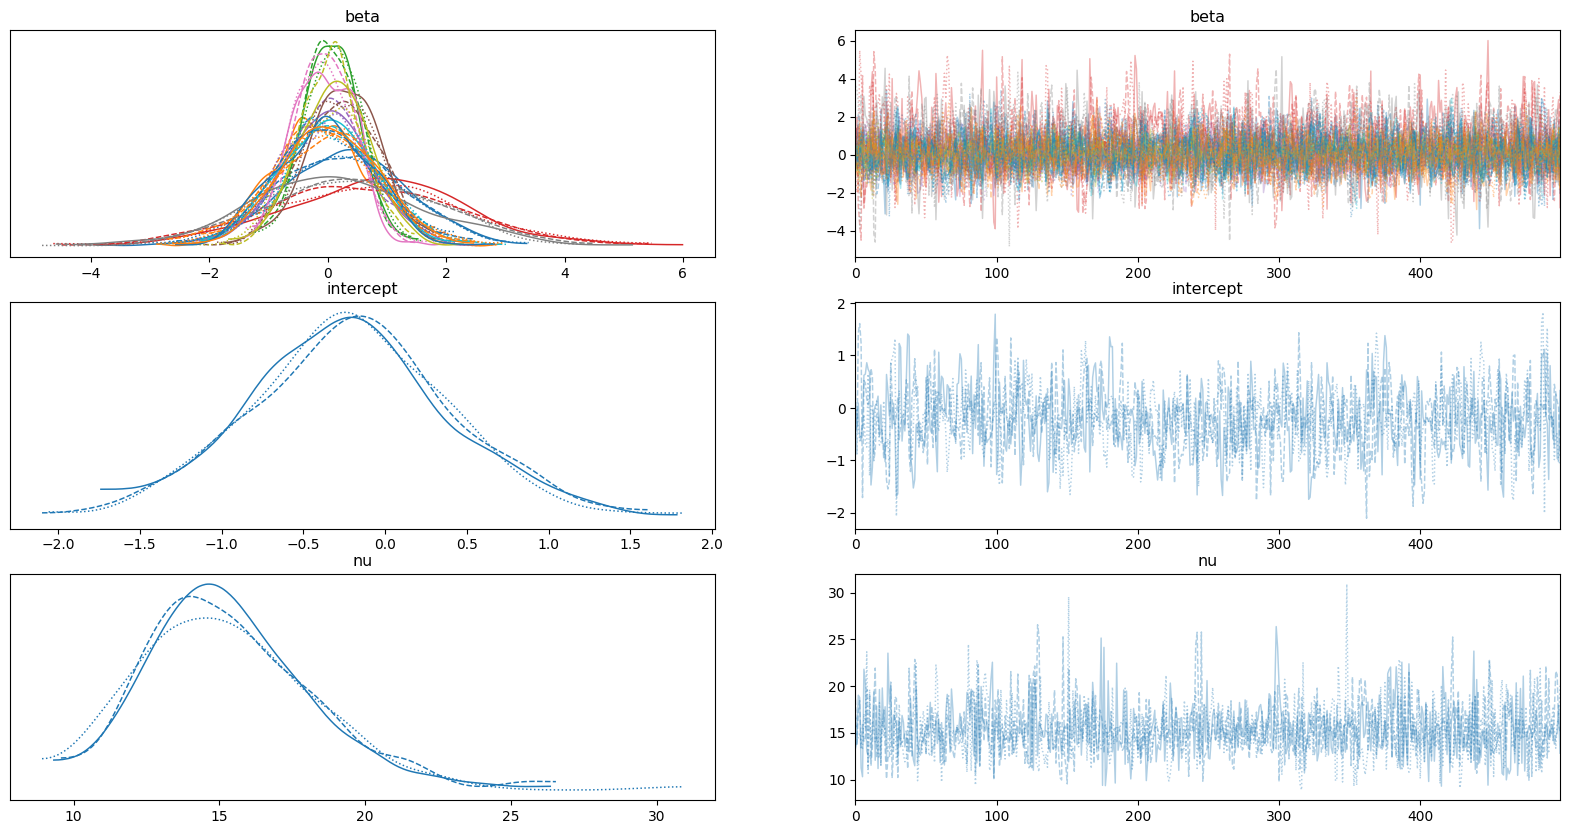

In [39]:
# Save and display posterior diagnostics
# posterior_summary = az.summary(student_t_summary)
az.plot_trace(trace_student_t, figsize=(20, 10), compact=True) #, var_names=scaled_data.columns
# plt.savefig("traceplot_beta_intercept_alpha.png")
plt.show()

In [40]:
trace_student_t

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

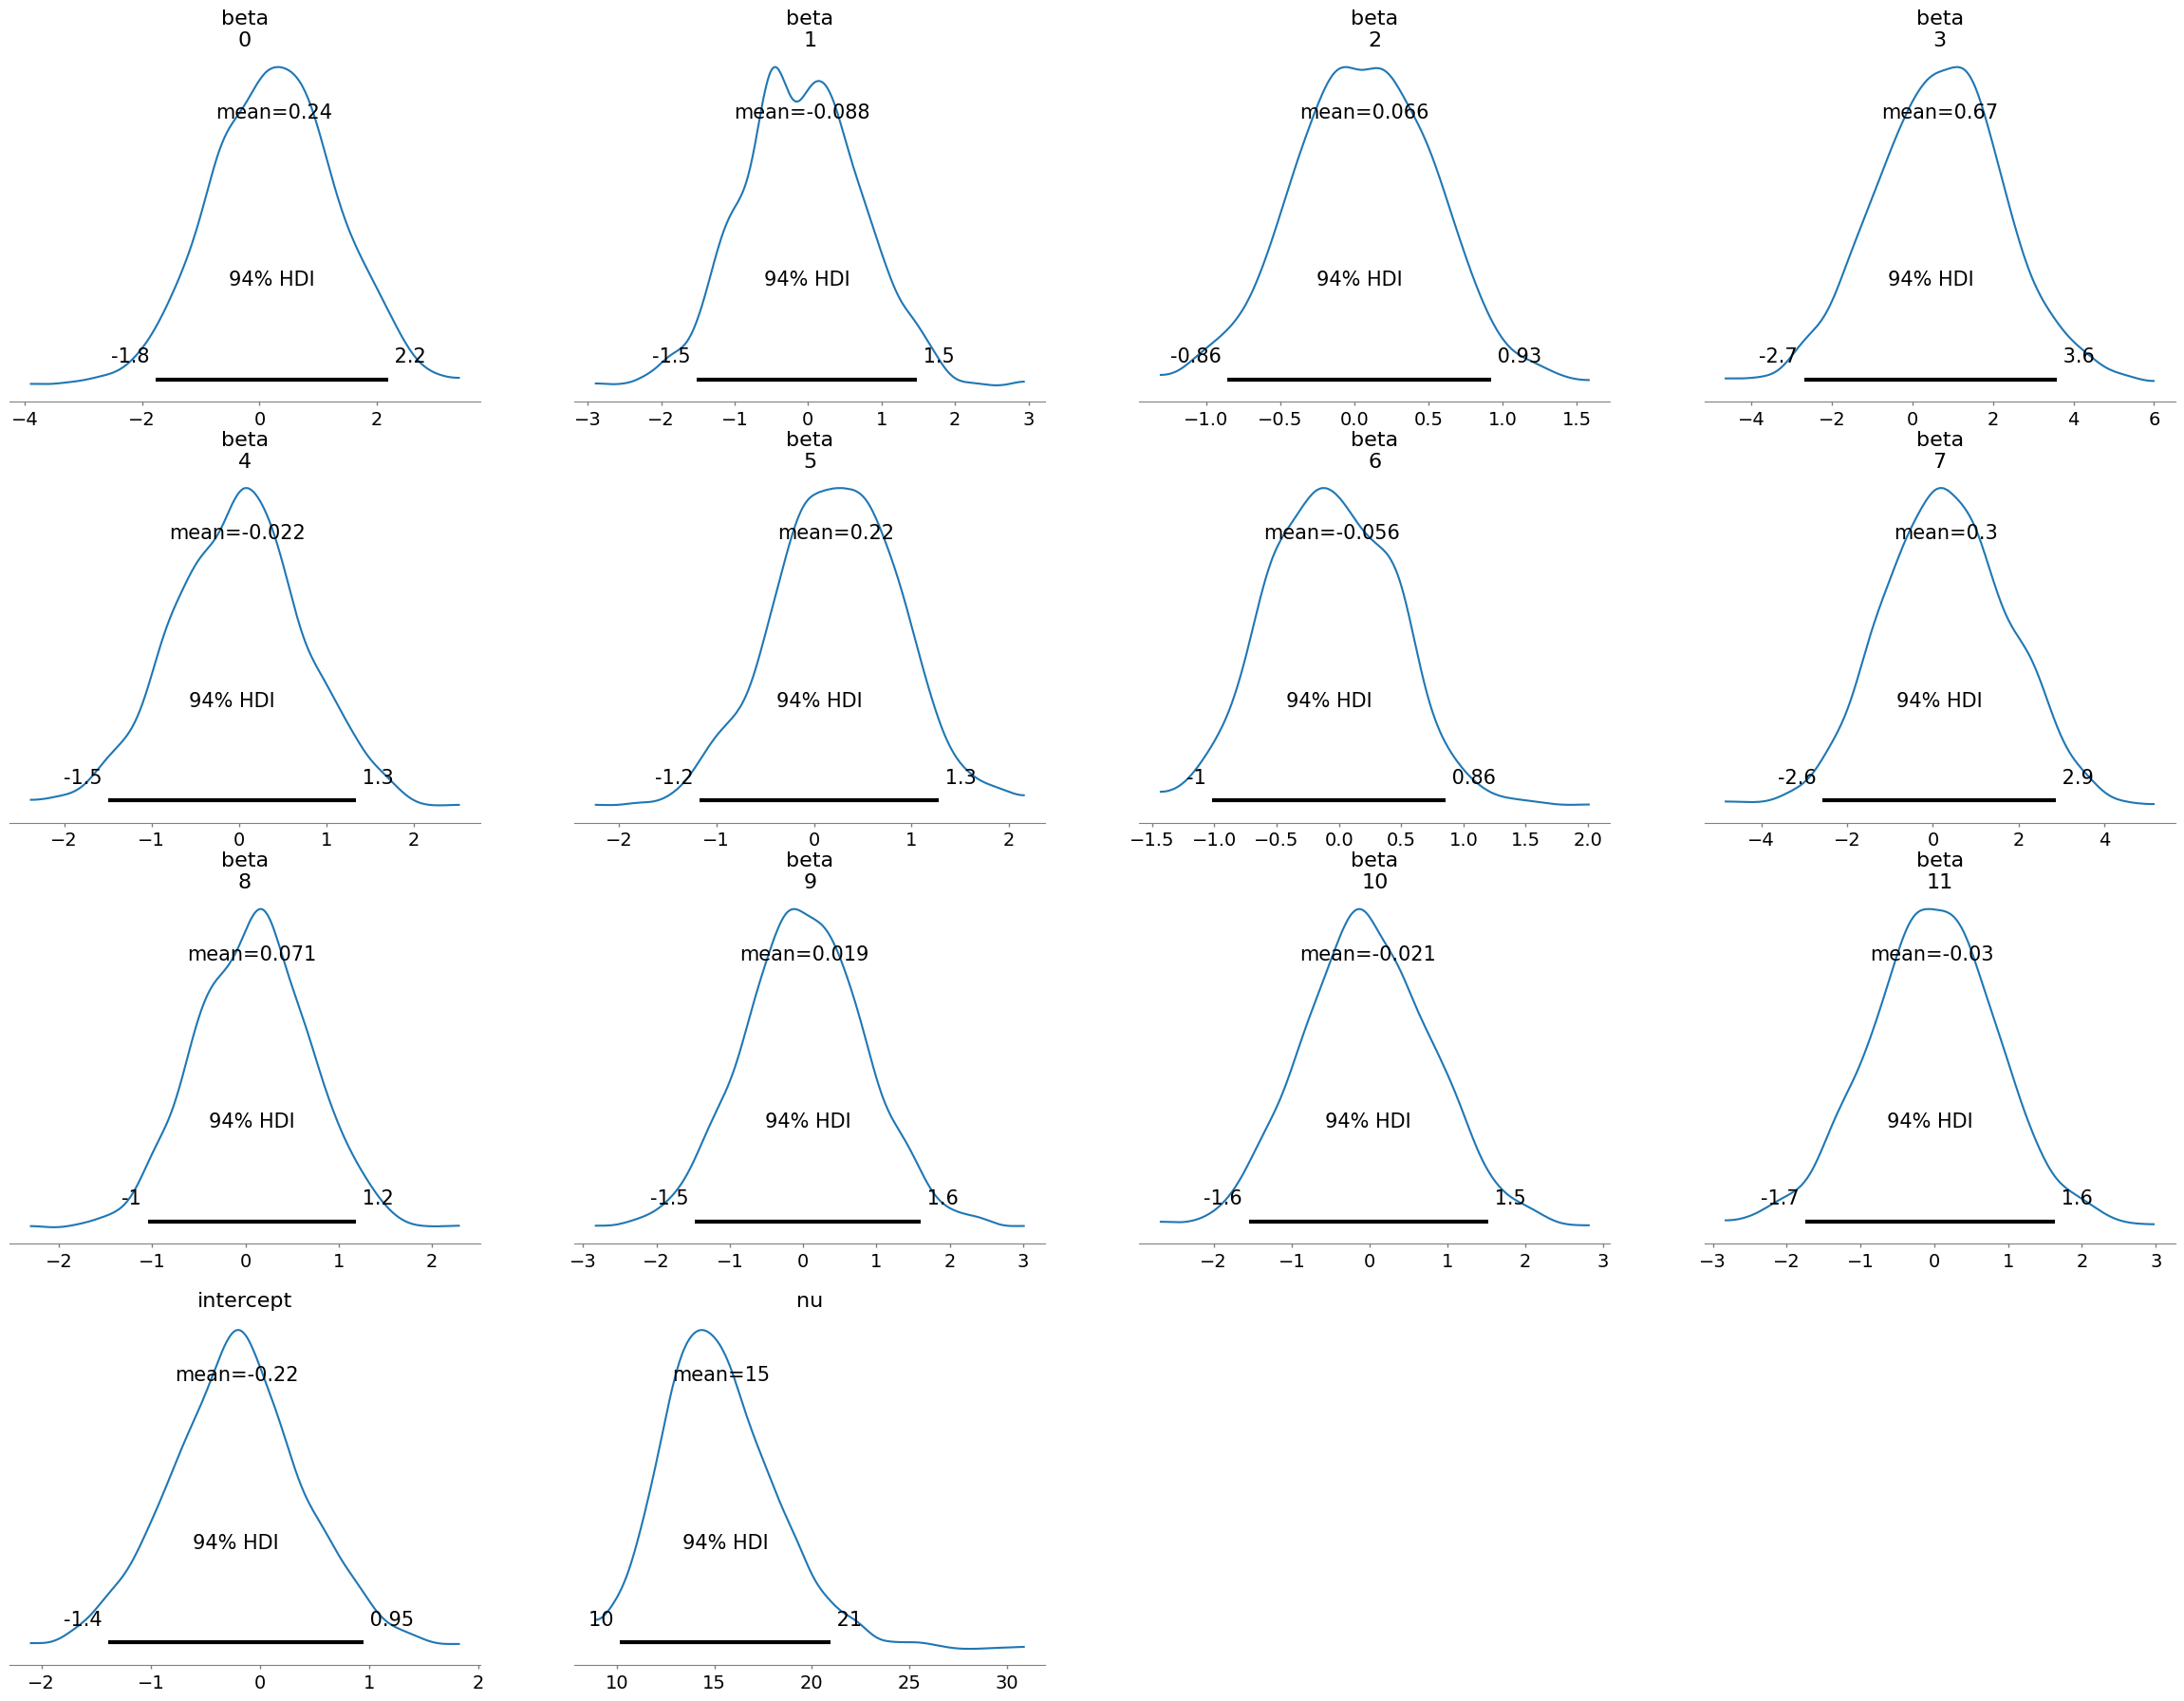

In [41]:
az.plot_posterior(trace_student_t.posterior)
# plt.savefig("posterior_beta_intercept_alpha.png")
plt.show()

In [42]:
student_beta_posterior = trace_student_t.posterior["beta"]

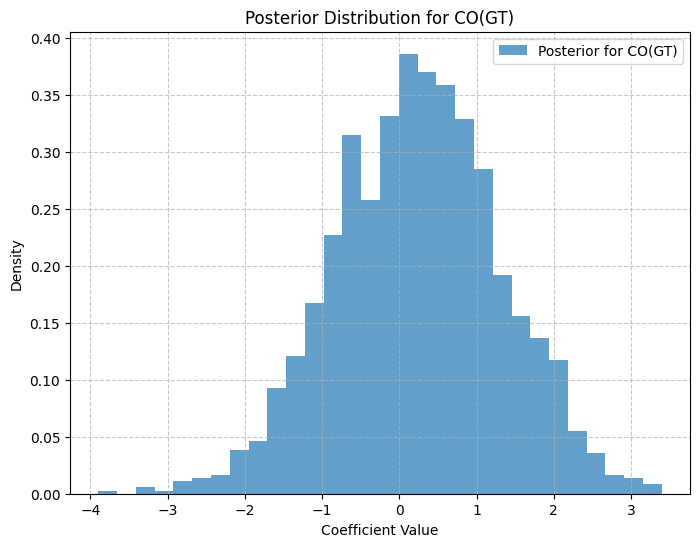

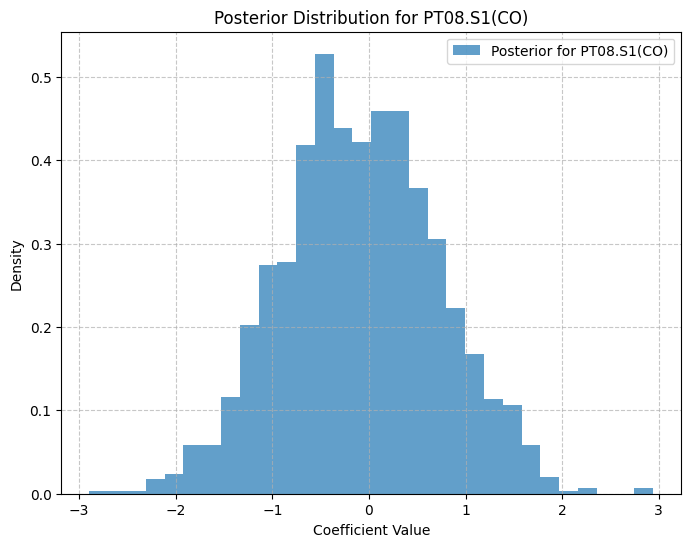

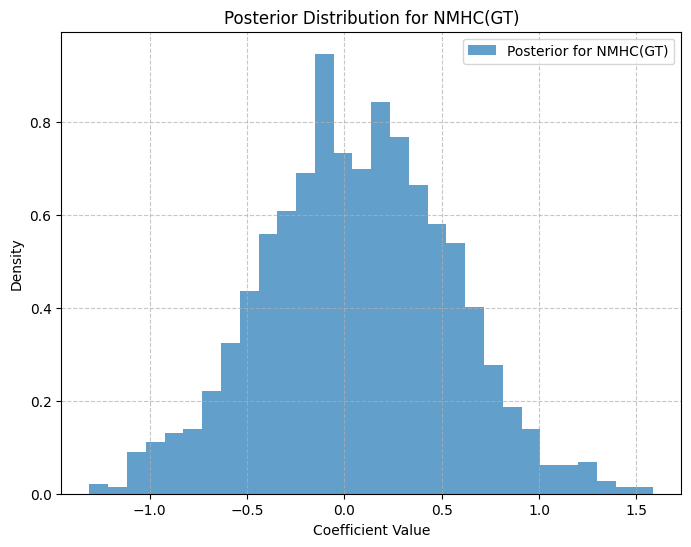

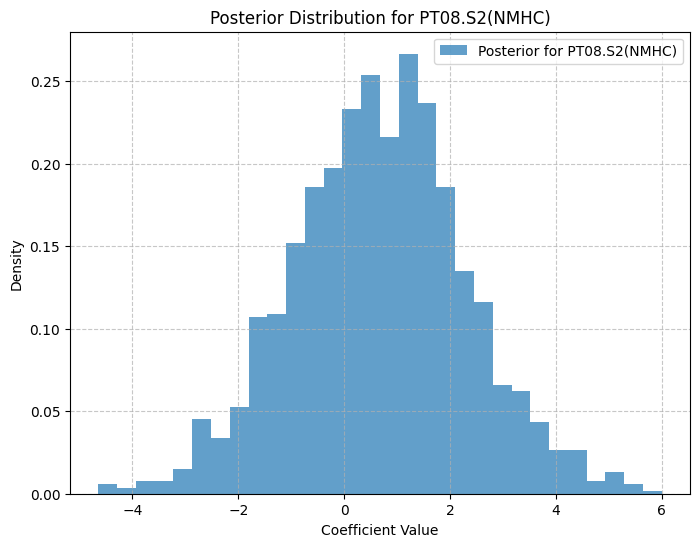

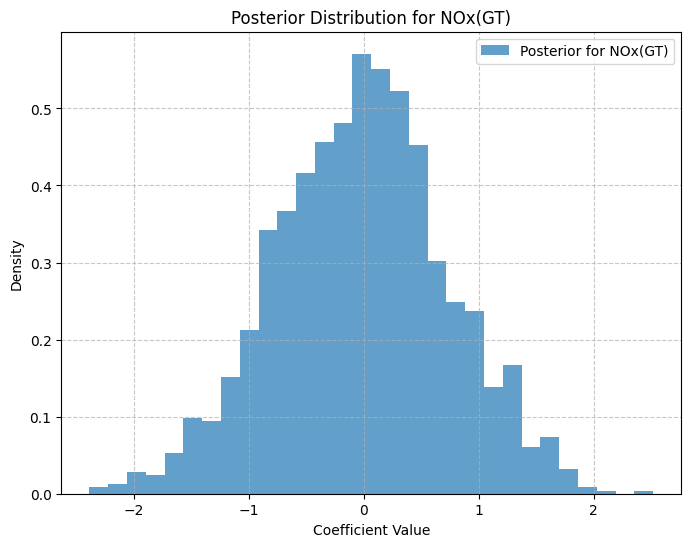

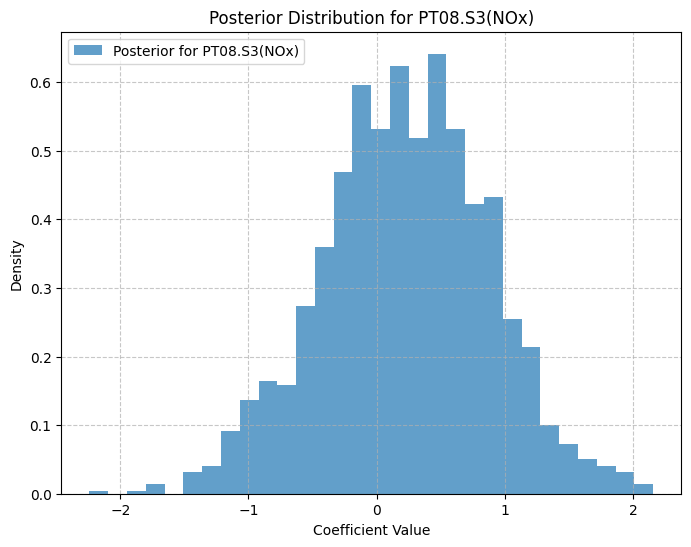

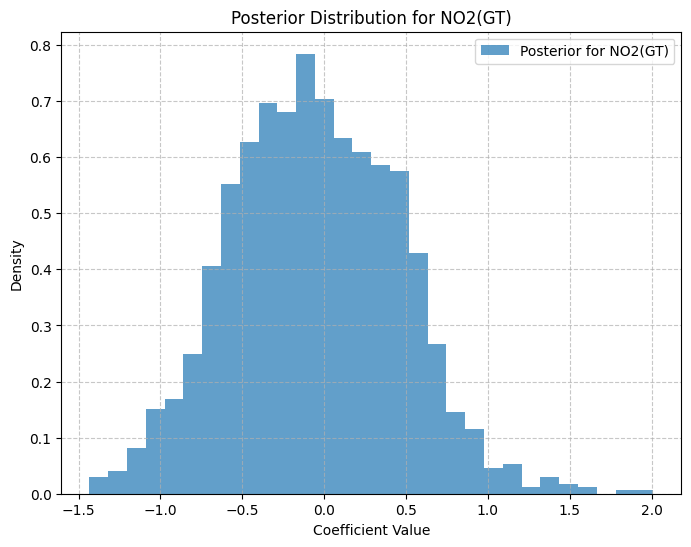

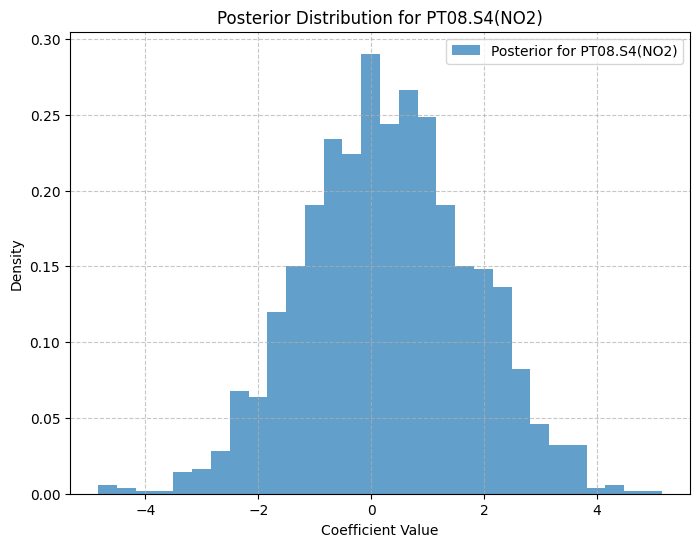

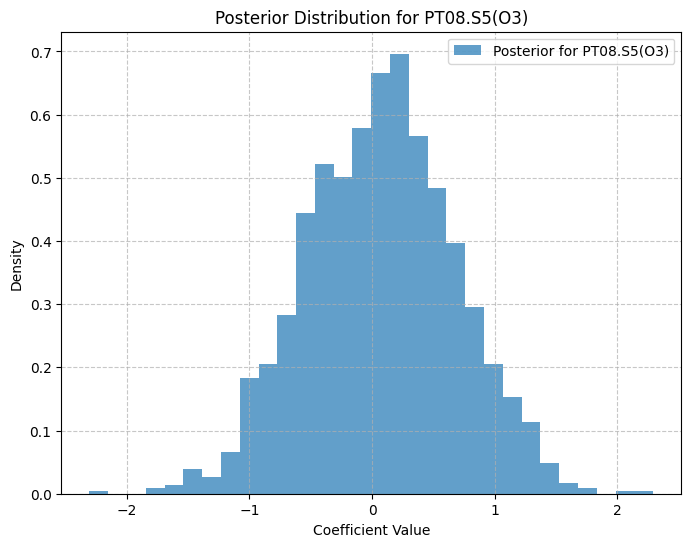

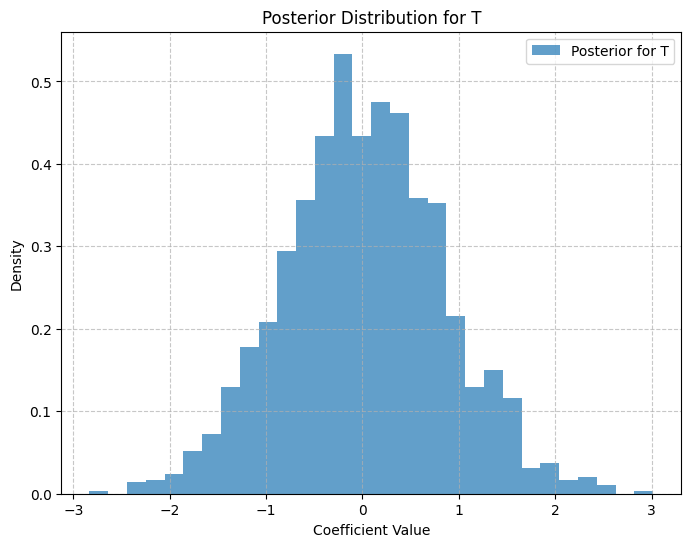

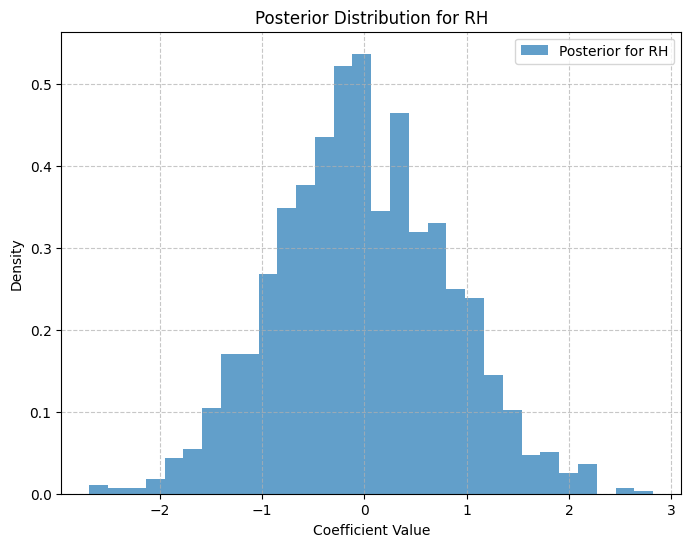

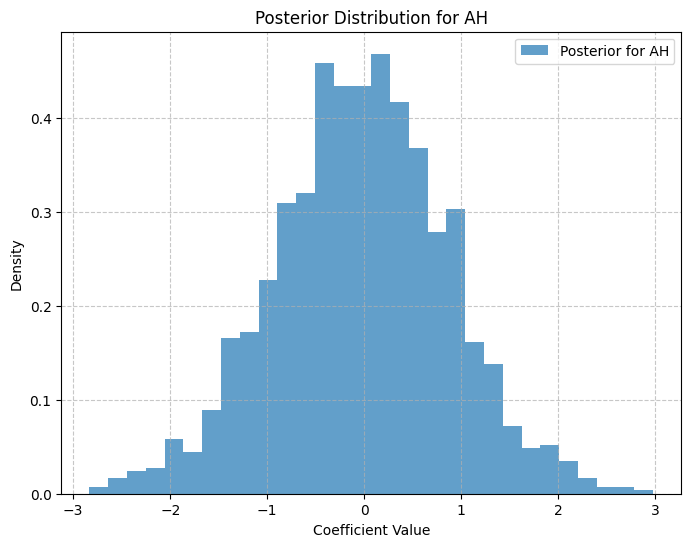

In [43]:
# Iterate through predictors and plot their posterior distributions
for i, predictor in enumerate(predictor_variables):
    # Extract posterior samples for the i-th predictor
    student_beta_predictor_posterior = student_beta_posterior.sel(beta_dim_0=i).values.flatten()  # Convert to NumPy array

    # Plot the posterior distribution
    plt.figure(figsize=(8, 6))
    plt.hist(student_beta_predictor_posterior, bins=30, density=True, alpha=0.7, label=f"Posterior for {predictor}")
    plt.title(f"Posterior Distribution for {predictor}")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

In [44]:
# Summarize the posterior
# 95% credible interval
student_posterior_summary = az.summary(trace_student_t, var_names=["beta"], hdi_prob=0.95)
print(student_posterior_summary)

           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]   0.241  1.074    -1.730      2.391      0.031    0.027    1251.0   
beta[1]  -0.088  0.809    -1.641      1.478      0.021    0.019    1514.0   
beta[2]   0.066  0.477    -0.925      0.944      0.012    0.011    1586.0   
beta[3]   0.674  1.644    -2.694      3.846      0.057    0.040     815.0   
beta[4]  -0.022  0.749    -1.586      1.359      0.021    0.019    1233.0   
beta[5]   0.225  0.654    -1.175      1.398      0.024    0.017     739.0   
beta[6]  -0.056  0.512    -1.036      0.921      0.012    0.011    1817.0   
beta[7]   0.305  1.477    -2.568      3.071      0.043    0.032    1166.0   
beta[8]   0.071  0.608    -1.067      1.259      0.015    0.023    1710.0   
beta[9]   0.019  0.833    -1.572      1.637      0.034    0.024     610.0   
beta[10] -0.021  0.834    -1.627      1.571      0.034    0.024     623.0   
beta[11] -0.030  0.892    -1.742      1.852      0.037    0.026     590.0   

In [45]:
student_posterior_summary

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]   0.241  1.074    -1.730      2.391      0.031    0.027    1251.0   
beta[1]  -0.088  0.809    -1.641      1.478      0.021    0.019    1514.0   
beta[2]   0.066  0.477    -0.925      0.944      0.012    0.011    1586.0   
beta[3]   0.674  1.644    -2.694      3.846      0.057    0.040     815.0   
beta[4]  -0.022  0.749    -1.586      1.359      0.021    0.019    1233.0   
beta[5]   0.225  0.654    -1.175      1.398      0.024    0.017     739.0   
beta[6]  -0.056  0.512    -1.036      0.921      0.012    0.011    1817.0   
beta[7]   0.305  1.477    -2.568      3.071      0.043    0.032    1166.0   
beta[8]   0.071  0.608    -1.067      1.259      0.015    0.023    1710.0   
beta[9]   0.019  0.833    -1.572      1.637      0.034    0.024     610.0   
beta[10] -0.021  0.834    -1.627      1.571      0.034    0.024     623.0   
beta[11] -0.030  0.892    -1.742      1.852      0.037    0.026     590.0   

          ess_tail  r_hat  
beta[0]      940.0   1.00  
beta[1]     1169.0   1.00  
beta[2]     1198.0   1.00  
beta[3]     1136.0   1.00  
beta[4]      881.0   1.00  
beta[5]      998.0   1.00  
beta[6]     1356.0   1.00  
beta[7]     1192.0   1.00  
beta[8]      735.0   1.01  
beta[9]      769.0   1.00  
beta[10]     726.0   1.00  
beta[11]     637.0   1.00

In [46]:
student_prior_beta_values

array([[ -1.38131295,  -3.69609742, -15.09761999, ...,   5.45186399,
         -4.64858023,   4.43128679],
       [-22.07266755,  -3.3575371 ,  -6.30251726, ...,  -0.44352416,
         -1.82176535,   1.88423672],
       [ -5.54164384,  12.74306941,  -2.63562861, ...,  16.61643001,
         -8.72432441,   5.11942763],
       ...,
       [  4.95412691,  12.13412293,  -2.99621384, ..., -12.39507933,
         10.70845332,  -5.26257605],
       [  4.58703871,  -5.9771727 ,  -0.15629125, ...,   3.11801086,
        -18.88285276,  -5.54899671],
       [-12.47323627,   1.74830294, -15.9957931 , ...,   6.89199018,
         -8.00631898,  -2.78977565]])

In [47]:
trace_student_t.posterior["beta"]

<xarray.DataArray 'beta' (chain: 3, draw: 500, beta_dim_0: 12)> Size: 144kB
array([[[ 0.02771862, -0.04970841,  0.82819307, ..., -0.31266071,
         -0.31216537,  0.37366401],
        [ 1.36546214, -0.509495  , -0.85266054, ..., -0.05968202,
         -0.14182455,  0.32038954],
        [ 0.63729931, -1.07086465, -0.12374496, ..., -0.33661601,
         -0.22347837,  0.29739765],
        ...,
        [ 0.56724459, -0.4142773 , -0.32473436, ...,  0.73213721,
          0.76271814, -0.28516803],
        [-0.65909698,  0.40317968, -0.11705795, ...,  0.86312941,
          1.00037756, -0.71100124],
        [ 0.46095135,  1.12154842,  1.14448002, ...,  1.30391337,
          1.03786638, -1.79697068]],

       [[ 0.61376282, -0.66935056, -0.64982004, ...,  0.1010925 ,
          0.08772709, -0.95291464],
        [-0.61820555, -1.05008999,  0.27638759, ...,  0.35948687,
         -0.05928552, -0.40566129],
        [-0.55547736, -1.92489849,  0.53799537, ...,  0.32885305,
          0.12847661, -0.56262093],
...
        [ 0.9026861 ,  0.74126898,  0.47889064, ...,  1.10390047,
          0.77652337, -0.49636011],
        [ 0.59055309, -0.5204138 ,  0.16713692, ...,  0.97064173,
          1.07609626, -0.80046782],
        [ 1.02074386,  0.22031864,  0.46647517, ...,  1.28245794,
          1.20511194, -0.30592345]],

       [[ 0.02757118,  1.23899716, -0.35863542, ..., -0.18525544,
         -0.51313908,  0.1607851 ],
        [-0.1099867 , -1.03857451,  0.63667313, ...,  0.45232891,
          0.31544164, -0.0482262 ],
        [ 2.14534398,  0.36629475,  0.33028929, ..., -0.53458828,
         -0.54567829, -0.03775119],
        ...,
        [-0.65516237,  0.89808033, -0.04943754, ...,  0.6769247 ,
          0.56485274, -1.31195331],
        [ 1.75836566, -1.32989722,  0.27849154, ..., -0.56348626,
         -0.89479487,  1.17485496],
        [-2.03517047,  1.02072277,  0.66409398, ..., -0.14390675,
          0.09231971,  0.10400432]]])
Coordinates:
  * chain       (chain) int32 12B 0 1 2
  * draw        (draw) int32 2kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * beta_dim_0  (beta_dim_0) int32 48B 0 1 2 3 4 5 6 7 8 9 10 11

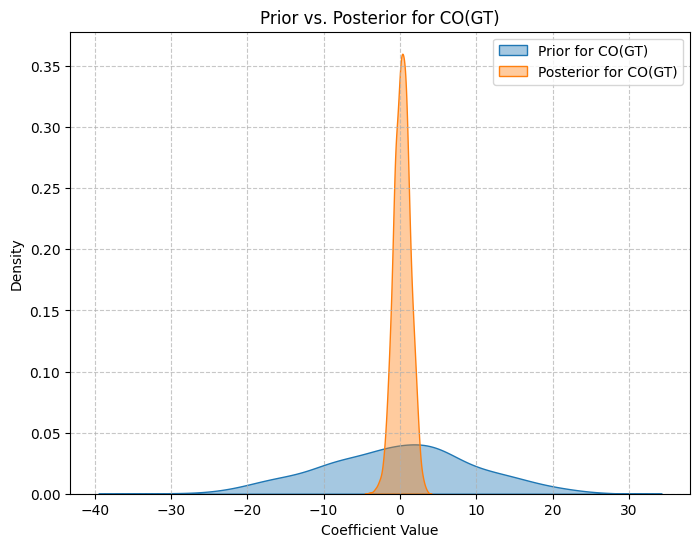

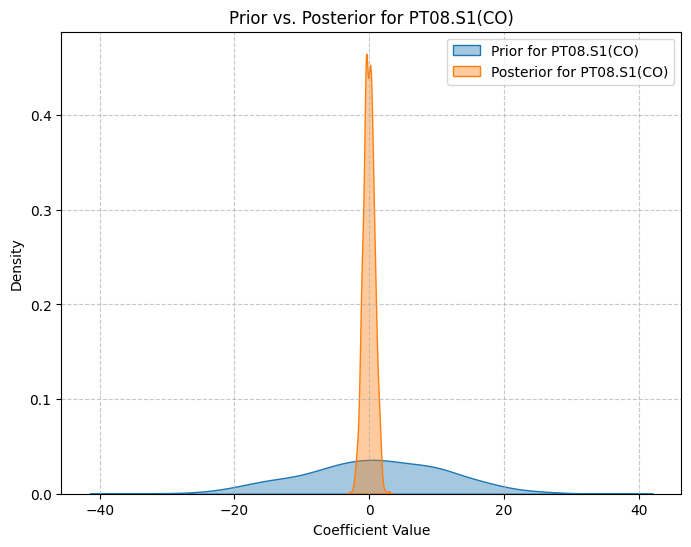

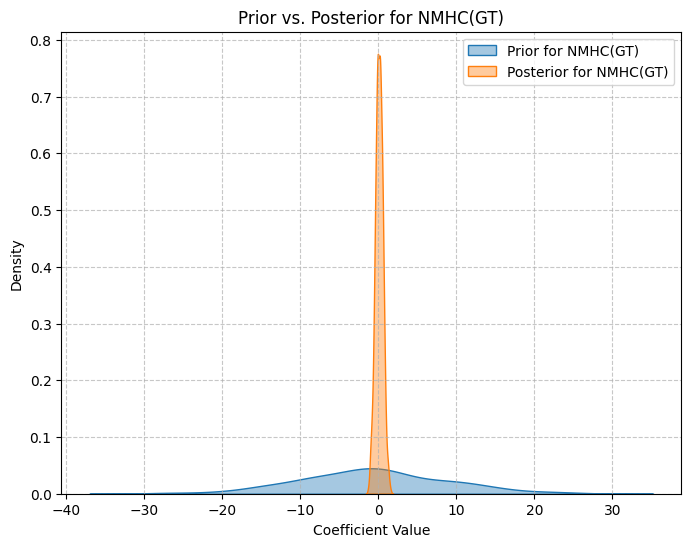

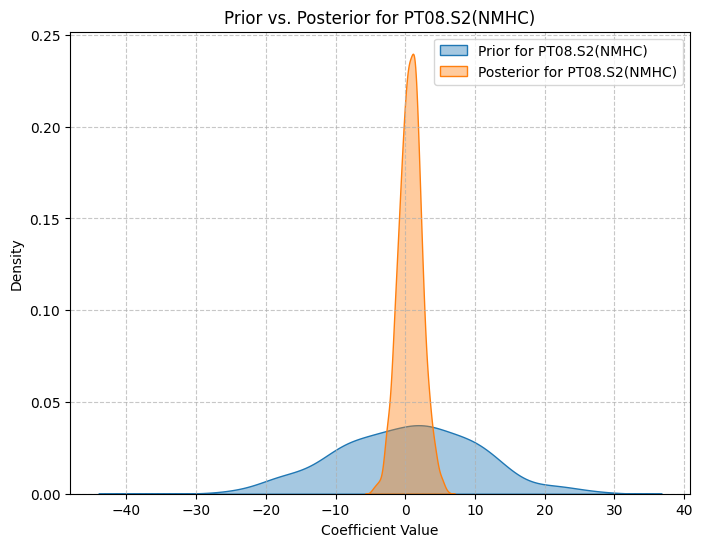

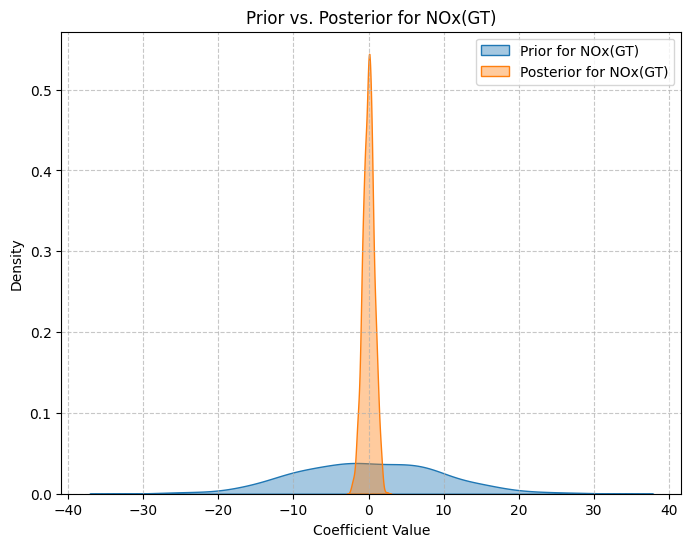

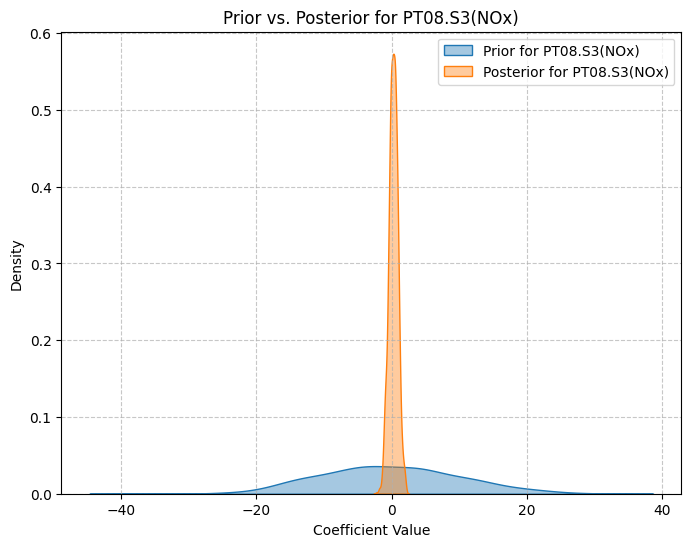

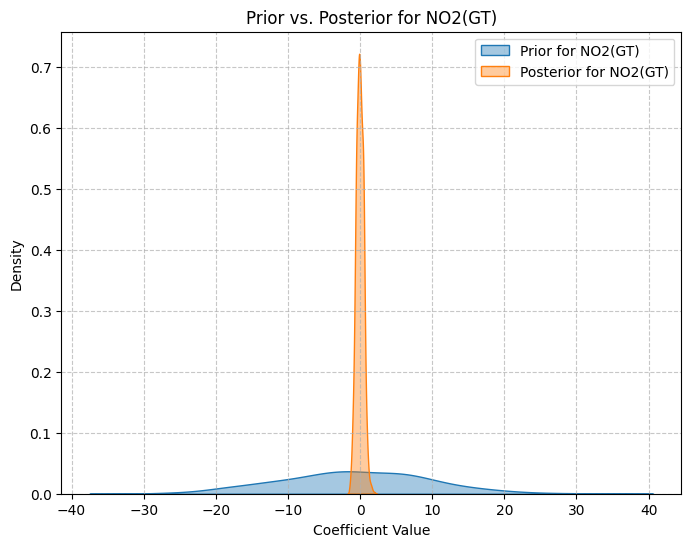

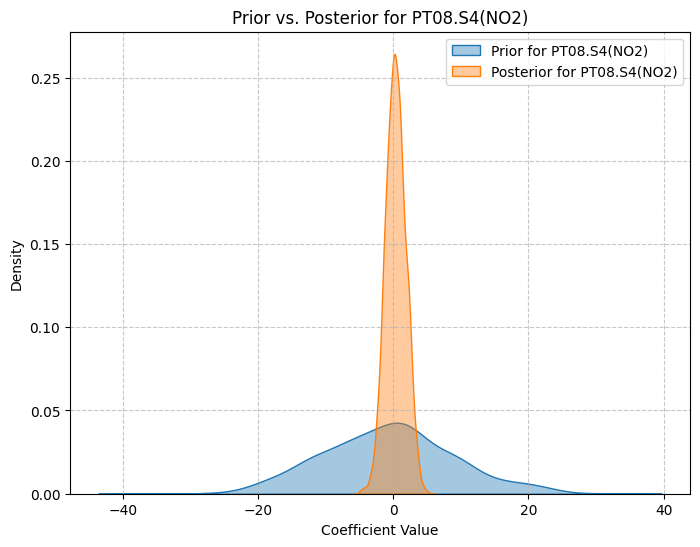

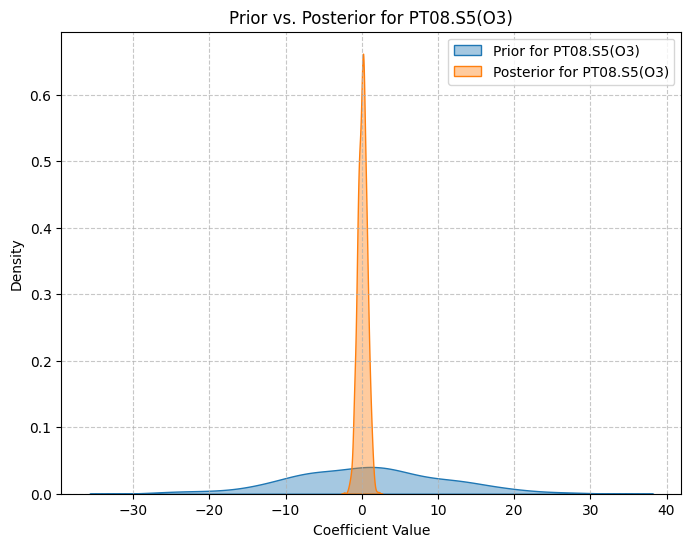

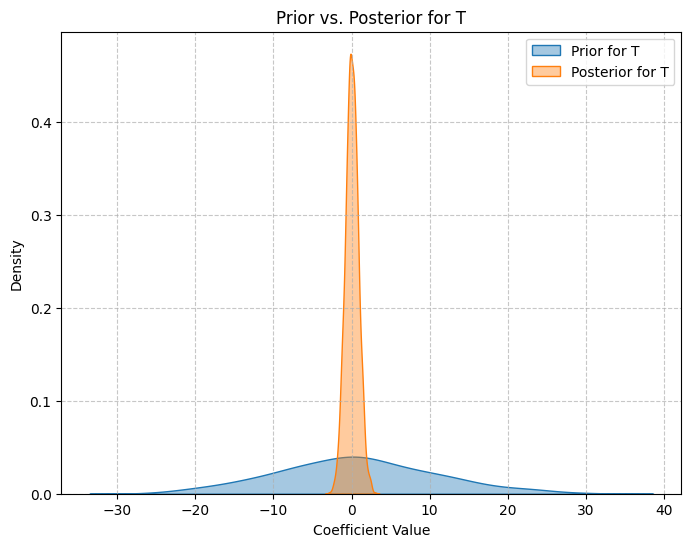

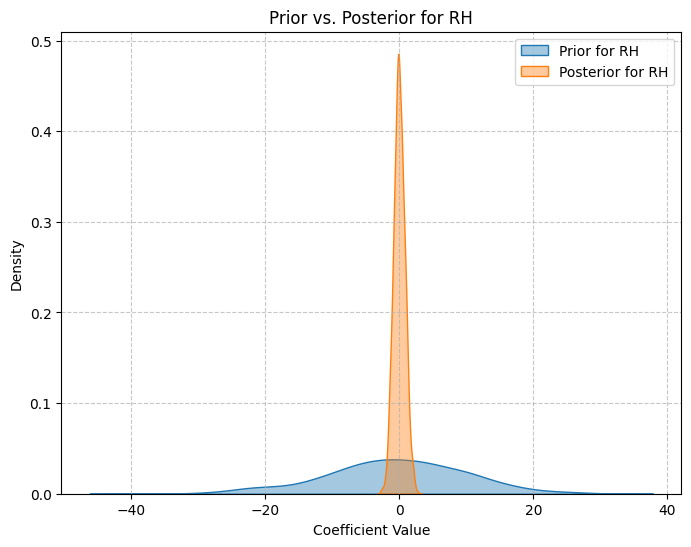

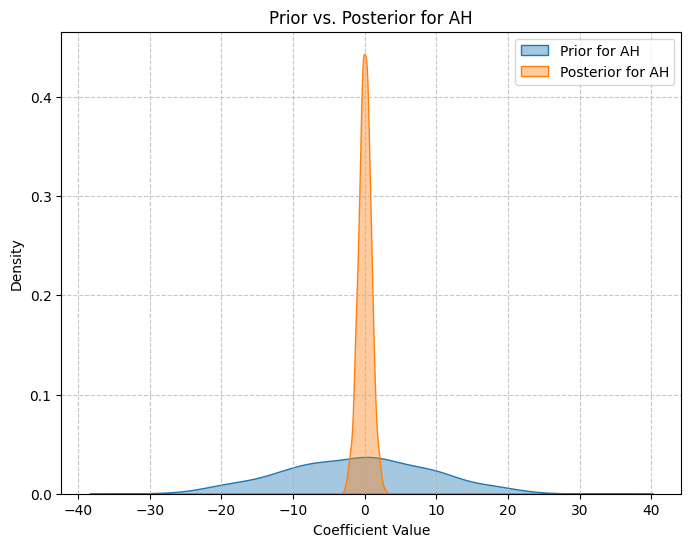

In [48]:
for i, predictor_name in enumerate(predictor_variables):
    # for posterior_gamma_beta in posterior_gamma_beta_values:
    # Extract prior and posterior for each predictor
    prior_samples = student_prior_beta_values[:, i]
    posterior_samples = trace_student_t.posterior["beta"].sel(beta_dim_0=i).values.flatten()
    # posterior_samples = idata.posterior["beta"].values.reshape((-1, idata.posterior["beta"].values.shape[1], idata.posterior["beta"].values.shape[2]))
    #idata.posterior["beta"].sel(beta_dim_0=i)#.values.flatten() #posterior_gamma_beta_values#
    # gamma_beta_posterior.sel(beta_dim_0=i).values.flatten()

    # Plot prior vs. posterior
    plt.figure(figsize=(8, 6))#(8, 6)
    # plt.hist(prior_samples, bins=100, density=True, alpha=0.5, label=f"Prior for {predictor_name}")
    # plt.hist(posterior_samples, bins=100, density=True, alpha=0.5, label=f"Posterior for {predictor_name}")
    sns.kdeplot(prior_samples, fill=True, alpha=0.4, label=f"Prior for {predictor_name}")
    sns.kdeplot(posterior_samples, fill=True, alpha=0.4, label=f"Posterior for {predictor_name}")
    plt.title(f"Prior vs. Posterior for {predictor_name}")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()


Student-t Model Evaluation

In [49]:
with student_t_model:
    # log_likelihood_gamma = 
    pm.compute_log_likelihood(trace_student_t)

Output()

In [50]:
# Compute WAIC and LOO for Model Comparison
try:
    # Compute WAIC
    waic = az.waic(trace_student_t)
    print(f"WAIC: {waic}")

    # Compute LOO
    gamma_loo = az.loo(trace_student_t)
    print(f"LOO: {loo}")

except Exception as e:
    print("Error in computing WAIC/LOO:", str(e))

WAIC: Computed from 1500 posterior samples and 827 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -780.70     0.21
p_waic        0.19        -
Error in computing WAIC/LOO: name 'loo' is not defined


Linear Model (Bayesian)

Linear Model Prior Check

In [51]:
# Define predictors and target
predictor_columns = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 
                    'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
X = scaled_data[predictor_columns].values  # Predictors

# Bayesian Linear Regression - Prior Model
with pm.Model() as linear_prior_model:
    # Priors for coefficients and intercept
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])  # Coefficients for predictors
    intercept = pm.Normal("intercept", mu=0, sigma=10)  # Intercept
    sigma = pm.HalfCauchy("sigma", beta=2)  # Noise standard deviation

    # Linear model
    mu = pm.math.dot(X, beta) + intercept  # Linear predictor

    # Likelihood (without observed data for prior predictive checks)
    target = pm.Normal("target", mu=mu, sigma=sigma)

    # Sample from the prior predictive distribution
    linear_prior_model = pm.sample_prior_predictive()

Sampling: [beta, intercept, sigma, target]


In [52]:
linear_prior_model

Inference data with groups:
	> prior

In [53]:
linear_prior_model_shape = linear_prior_model["prior"]["beta"].shape
linear_prior_model_shape

(1, 500, 12)

In [57]:
prior_linear_beta_values = linear_prior_model["prior"]["beta"].values.reshape(linear_prior_model_shape[1], linear_prior_model_shape[2])
prior_linear_beta_values.shape

(500, 12)

In [58]:
prior_linear_intercept = linear_prior_model["prior"]["intercept"].values.flatten()
type(prior_linear_intercept)

numpy.ndarray

In [59]:
prior_lienar_sigma = linear_prior_model["prior"]["sigma"].values.flatten()
type(prior_lienar_sigma)

numpy.ndarray

In [60]:
prior_lienar_target = linear_prior_model["prior"]["target"].values.flatten()
type(prior_lienar_target)

numpy.ndarray

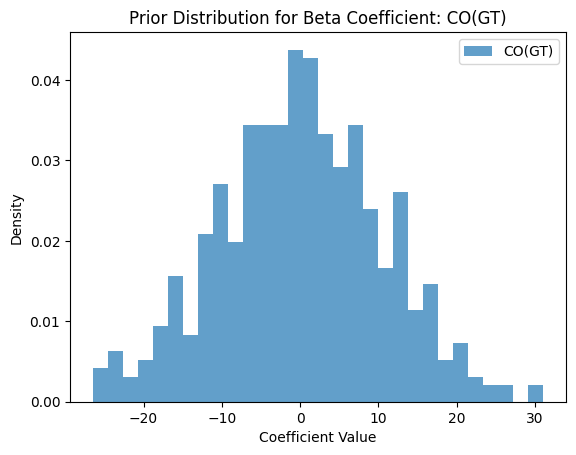

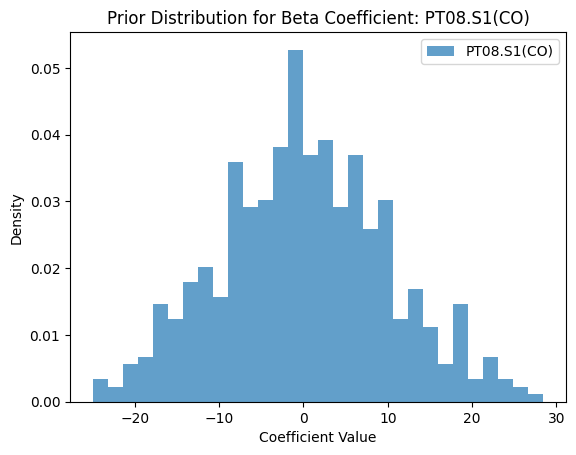

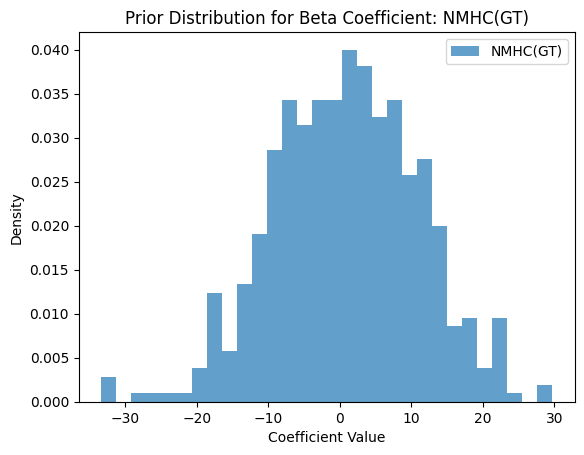

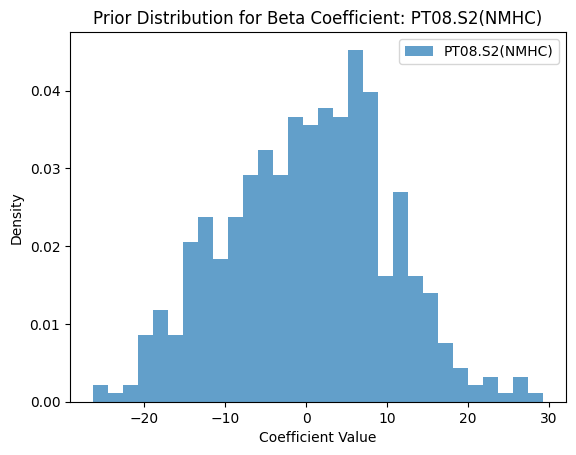

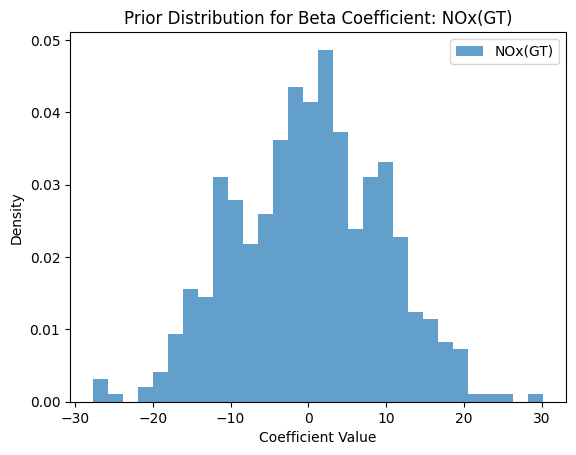

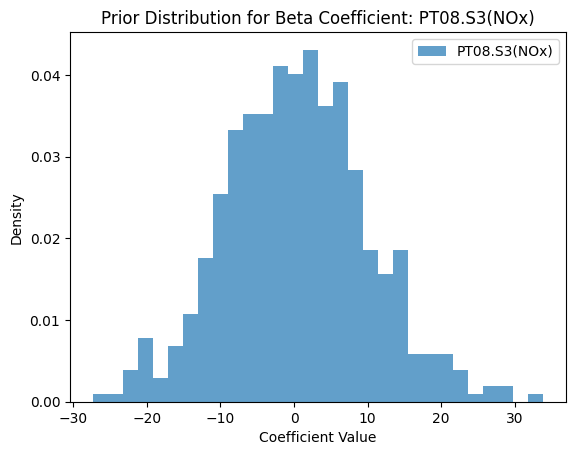

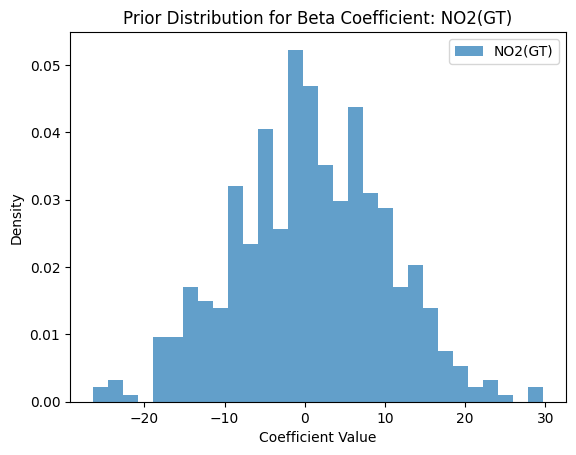

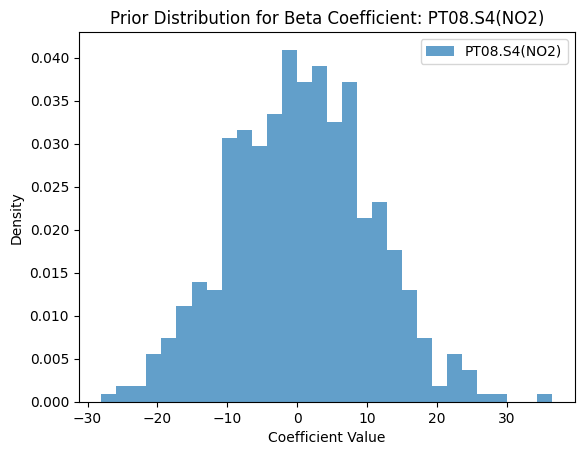

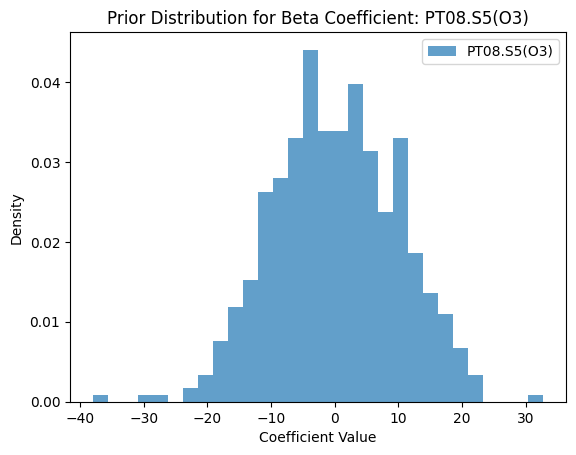

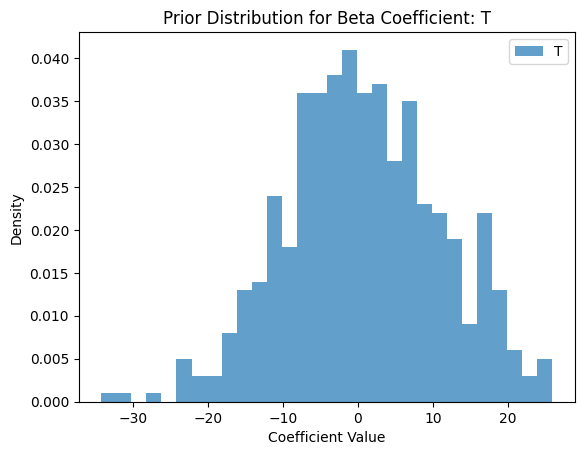

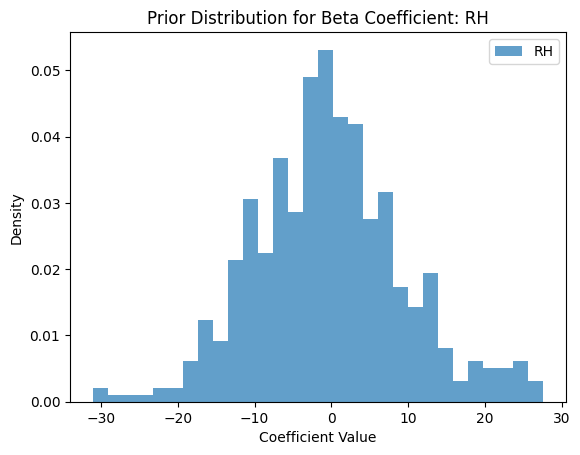

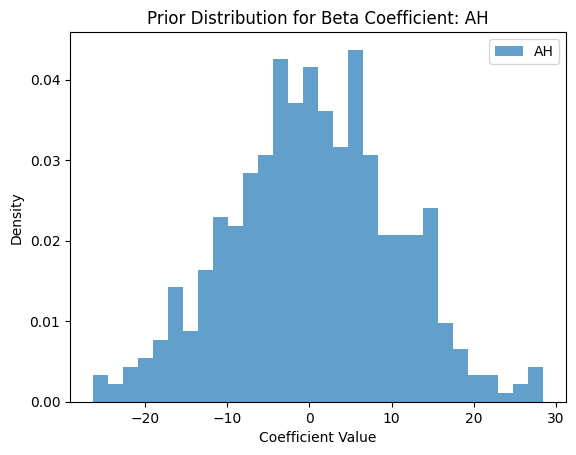

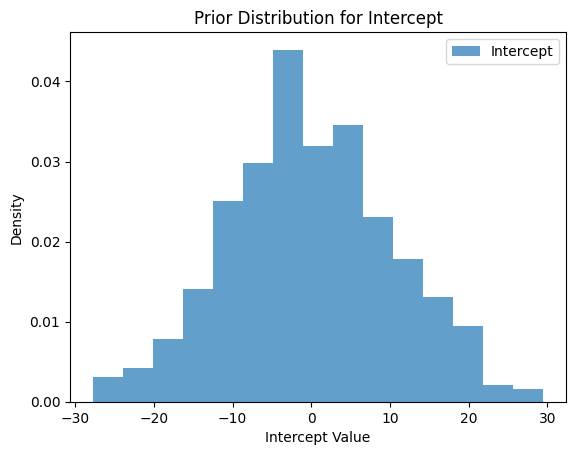

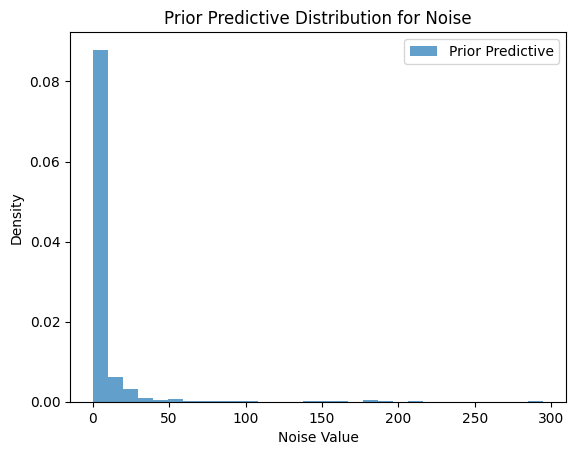

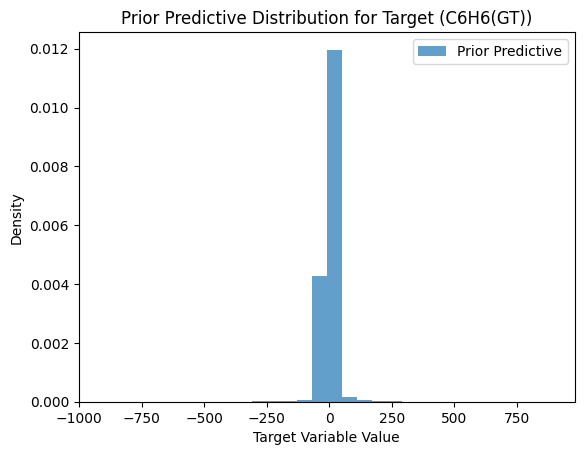

In [61]:
# Plot prior distributions for coefficients
for i, predictor in enumerate(predictor_columns):
    plt.hist(prior_linear_beta_values[:, i], bins=30, density=True, alpha=0.7, label=f"{predictor}")
    plt.title(f"Prior Distribution for Beta Coefficient: {predictor}")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Plot prior for intercept
plt.hist(prior_linear_intercept, bins=15, density=True, alpha=0.7, label="Intercept")
plt.title("Prior Distribution for Intercept")
plt.xlabel("Intercept Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# Plot prior predictive distribution of the target variable
plt.hist(prior_lienar_sigma, bins=30, density=True, alpha=0.7, label="Prior Predictive")
plt.title("Prior Predictive Distribution for Noise")
plt.xlabel("Noise Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# Plot prior predictive distribution of the target variable
plt.hist(prior_lienar_target, bins=30, density=True, alpha=0.7, label="Prior Predictive")
plt.title("Prior Predictive Distribution for Target (C6H6(GT))")
plt.xlabel("Target Variable Value")
plt.ylabel("Density")
plt.legend()
plt.show()

Linear Model (Bayesian): Posterior Check

In [62]:
# Define predictors and target
predictor_columns = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 
                    'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
X = scaled_data[predictor_columns].values  # Predictors
y = scaled_data["C6H6(GT)"].values  # Target variable

# Ensure the target is strictly positive
if (y <= 0).any():
    y += 0.001

# Bayesian Linear Regression
with pm.Model() as linear_model:
    # Priors for coefficients and intercept
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])  # Coefficients for predictors
    intercept = pm.Normal("intercept", mu=0, sigma=10)  # Intercept
    sigma = pm.HalfCauchy("sigma", beta=2)  # Noise standard deviation

    # Linear model
    mu = pm.math.dot(X, beta) + intercept  # Linear predictor

    # Likelihood
    target = pm.Normal("target", mu=mu, sigma=sigma, observed=y)

    # Sampling
    linear_trace = pm.sample(500, tune=500, return_inferencedata=True)

    # Posterior predictive checks
    linear_posterior_predictive = pm.sample_posterior_predictive(linear_trace, model=linear_model)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta, intercept, sigma]


Output()

Sampling 3 chains for 500 tune and 500 draw iterations (1_500 + 1_500 draws total) took 36 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [target]


Output()

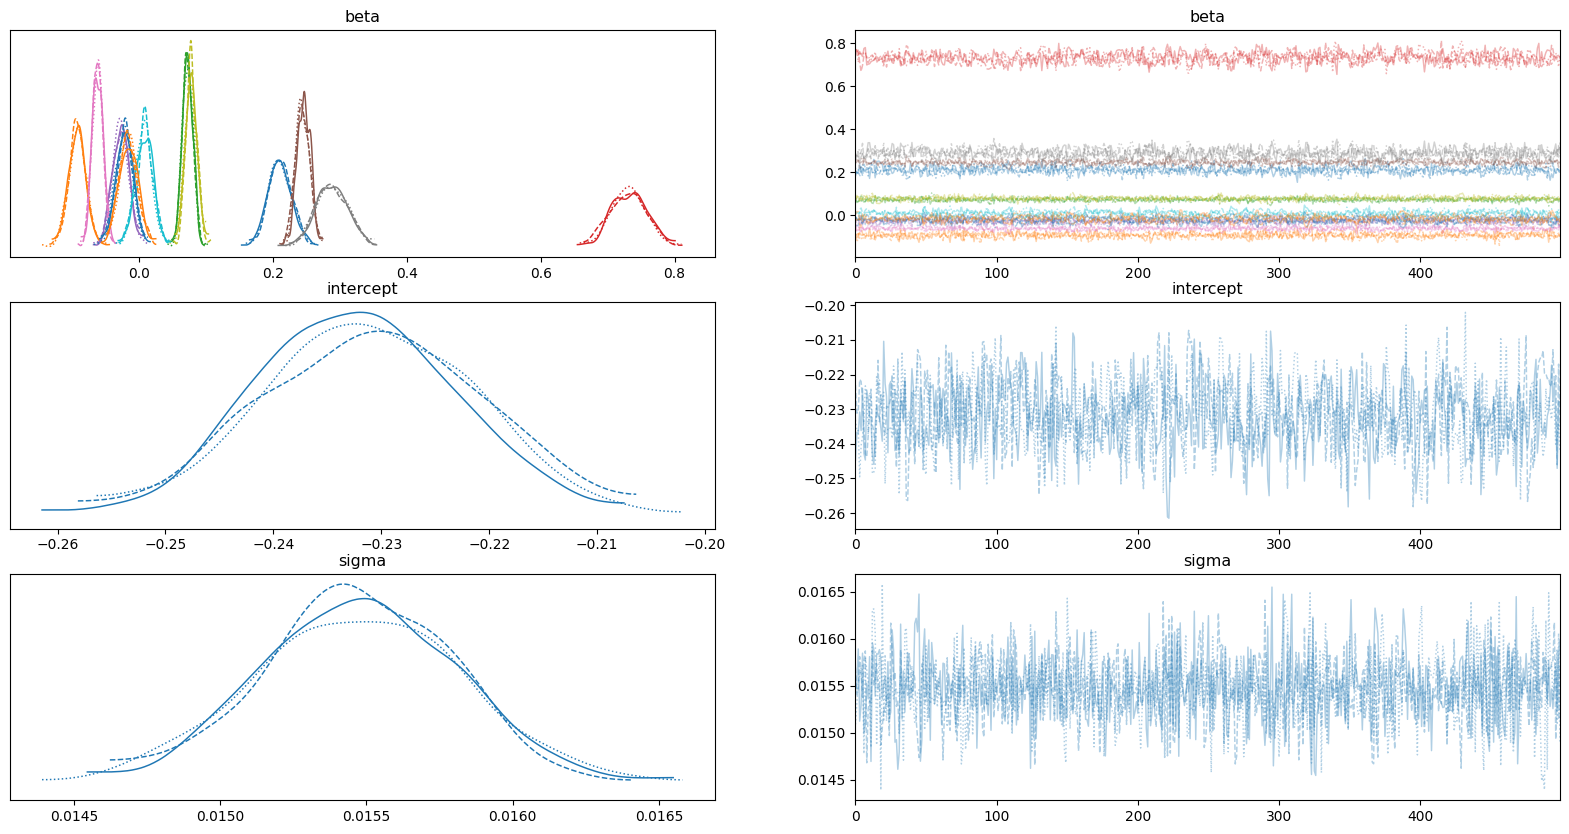

In [63]:
az.plot_trace(linear_trace, figsize=(20, 10), compact=True)
plt.show()

In [64]:
linear_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

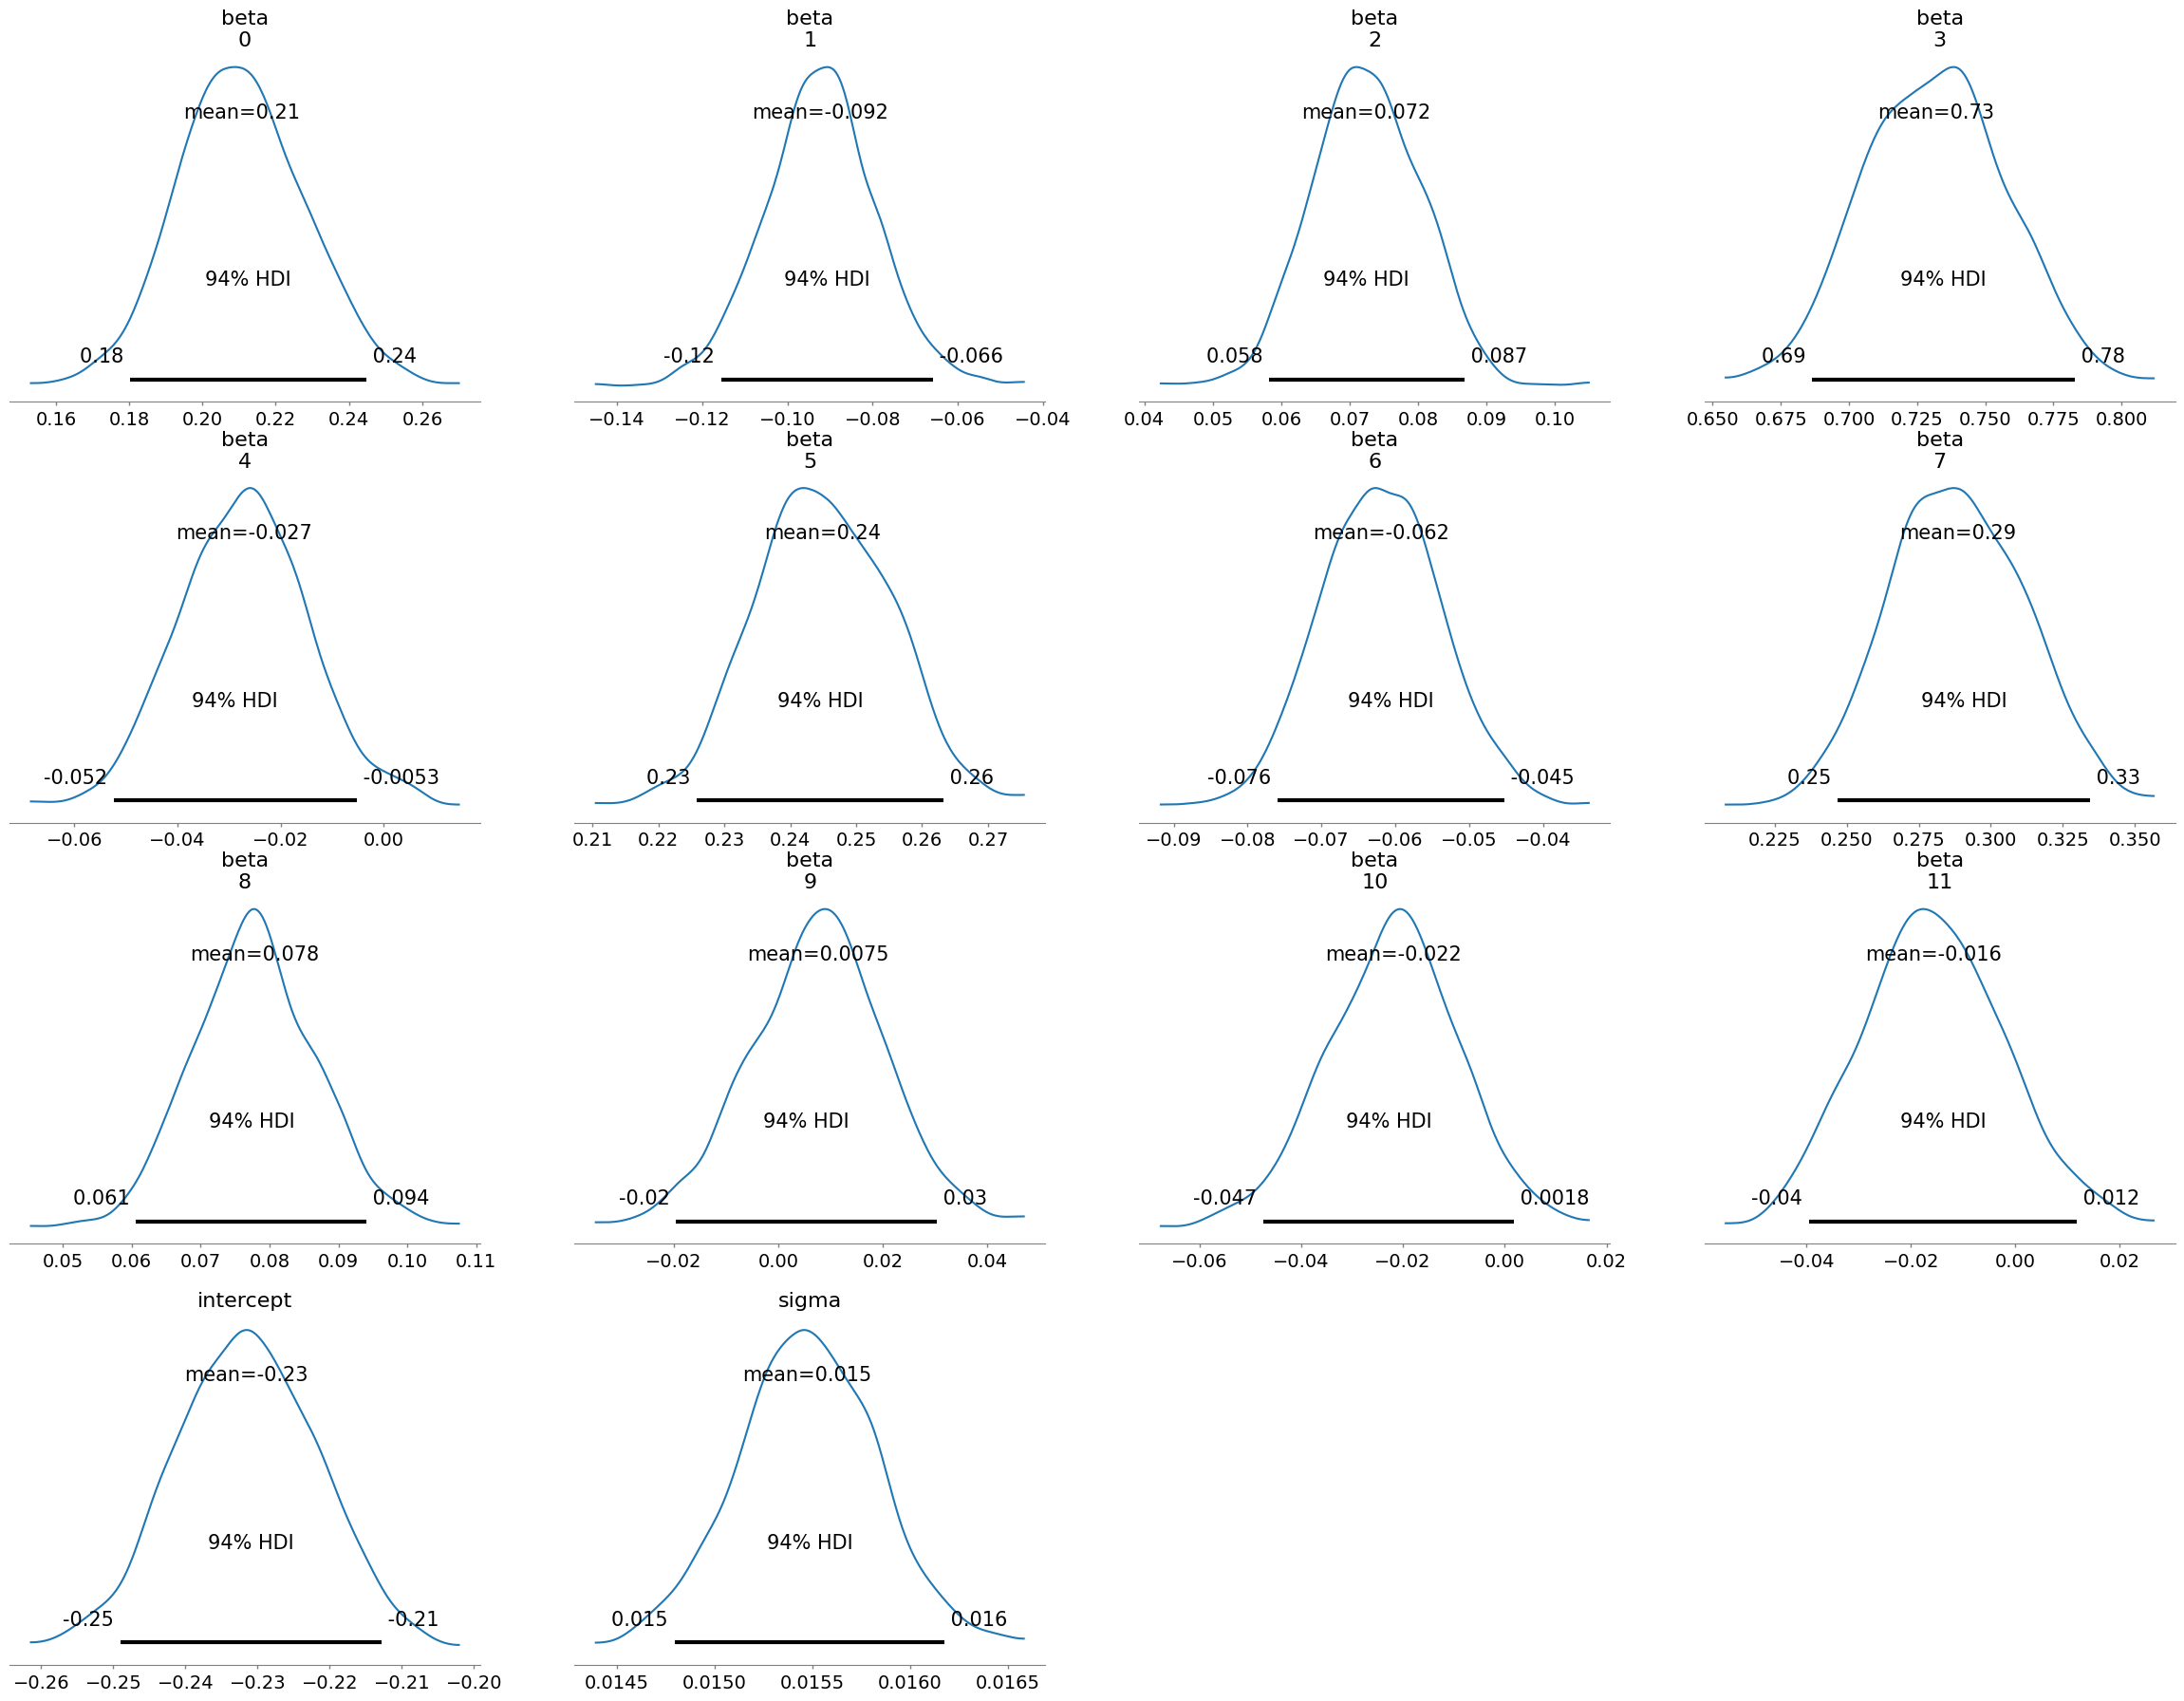

In [65]:
az.plot_posterior(linear_trace.posterior)
# plt.savefig("posterior_beta_intercept_alpha.png")
plt.show()

In [66]:
# Extract posterior samples for beta
linear_beta_posterior = linear_trace.posterior["beta"]
print(linear_beta_posterior)

<xarray.DataArray 'beta' (chain: 3, draw: 500, beta_dim_0: 12)> Size: 144kB
array([[[ 0.18302129, -0.08471933,  0.07862157, ...,  0.01634057,
         -0.00636969, -0.01827699],
        [ 0.20078444, -0.10411723,  0.05908002, ...,  0.01394877,
         -0.014374  , -0.02446963],
        [ 0.1991696 , -0.09252381,  0.06340724, ...,  0.00851993,
         -0.02147986, -0.01812505],
        ...,
        [ 0.2160082 , -0.10210213,  0.08184304, ...,  0.01720334,
         -0.00765354, -0.01537716],
        [ 0.20499553, -0.09279772,  0.06243561, ..., -0.01030286,
         -0.0290635 , -0.02046322],
        [ 0.20859373, -0.09163631,  0.06838572, ..., -0.00666511,
         -0.03112948, -0.01495984]],

       [[ 0.22088614, -0.06910691,  0.07902245, ...,  0.00995143,
         -0.01506416, -0.01638624],
        [ 0.18929538, -0.09720066,  0.07780697, ...,  0.00929915,
         -0.01167608, -0.0210198 ],
        [ 0.21215835, -0.07839508,  0.07295589, ...,  0.01130186,
         -0.02195551, -0.02

In [67]:
linear_prior_beta_shape = linear_prior_model["prior"]["beta"].shape
linear_prior_beta_shape

(1, 500, 12)

In [68]:
linear_prior_beta_values = linear_prior_model["prior"]["beta"].values.reshape(
    linear_prior_beta_shape[1], linear_prior_beta_shape[2])
linear_prior_beta_values.shape

(500, 12)

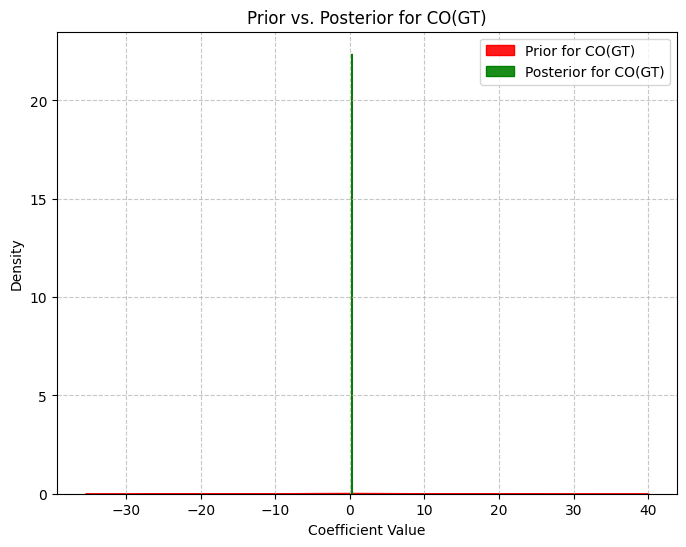

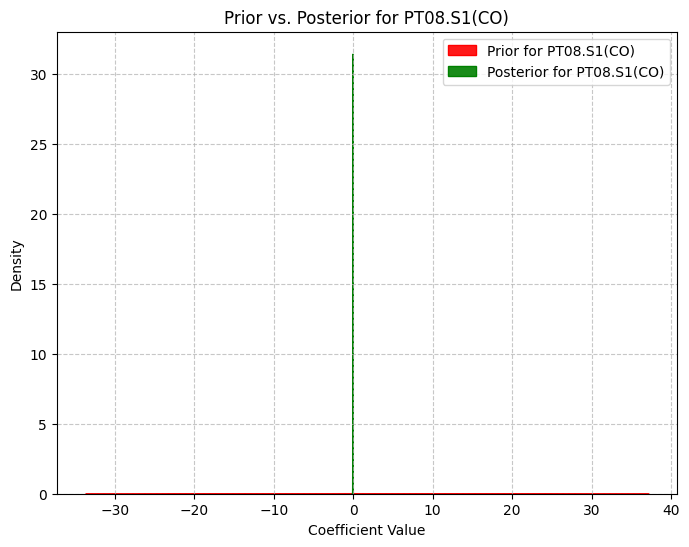

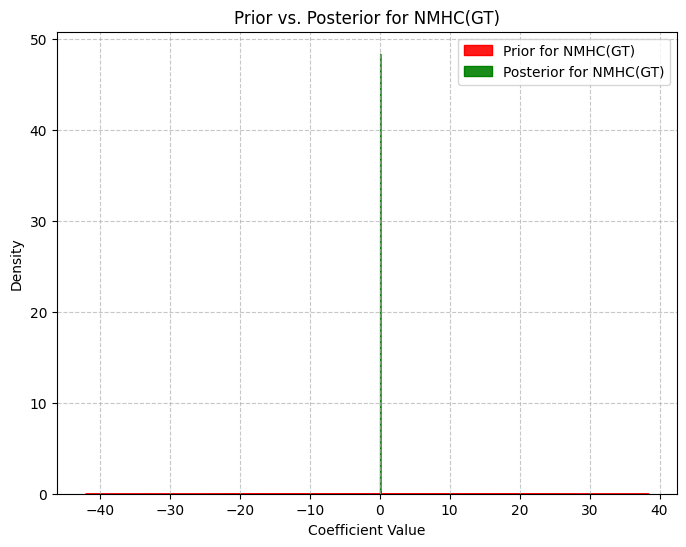

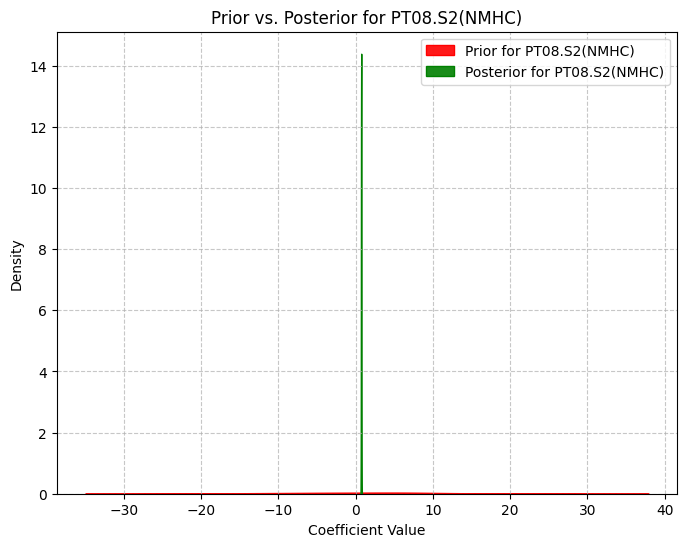

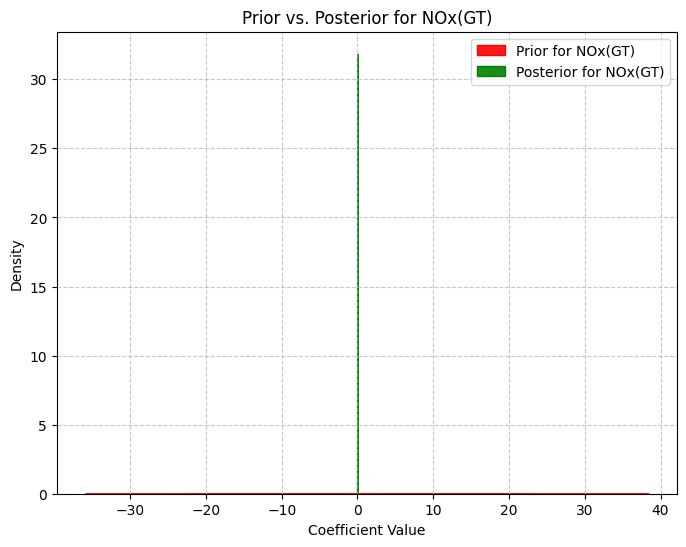

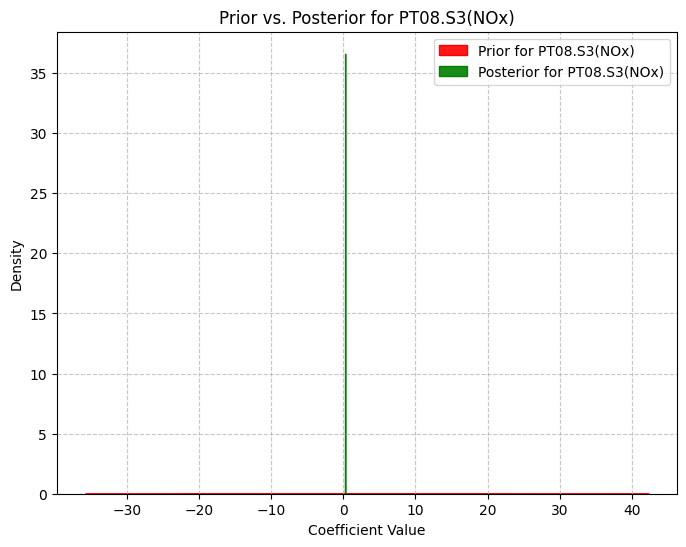

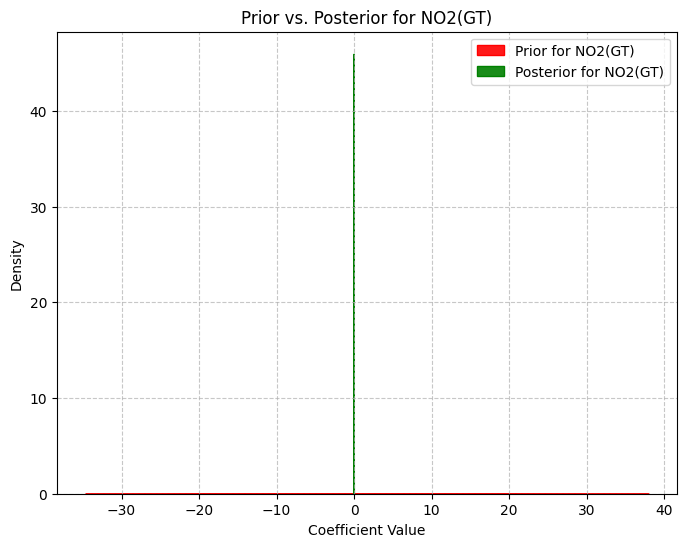

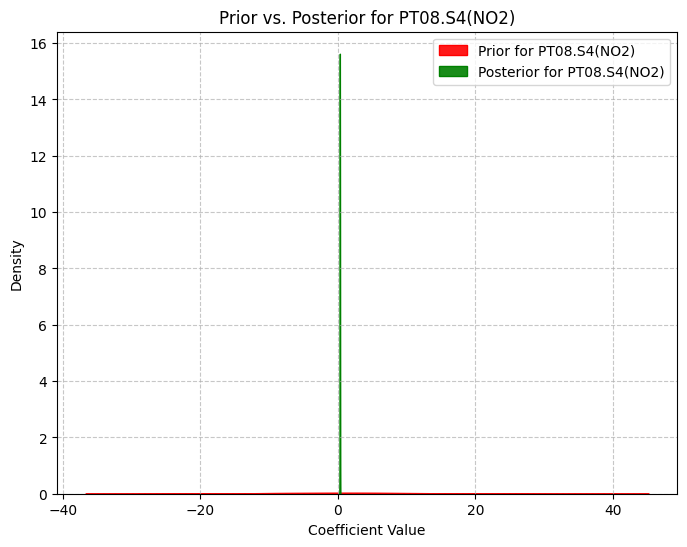

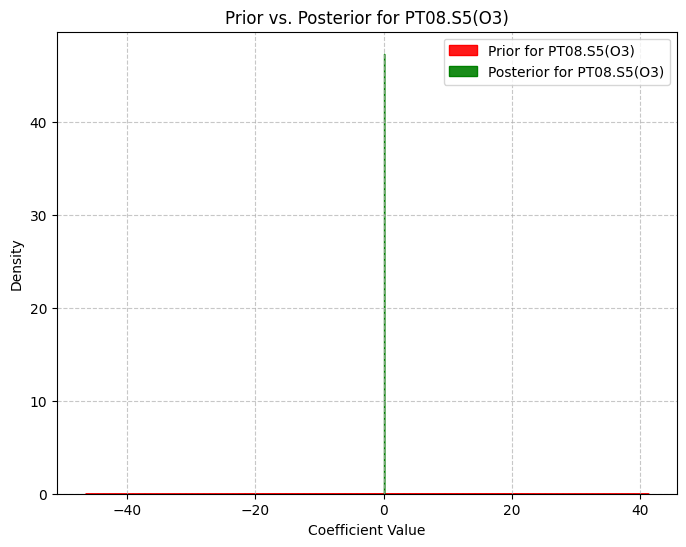

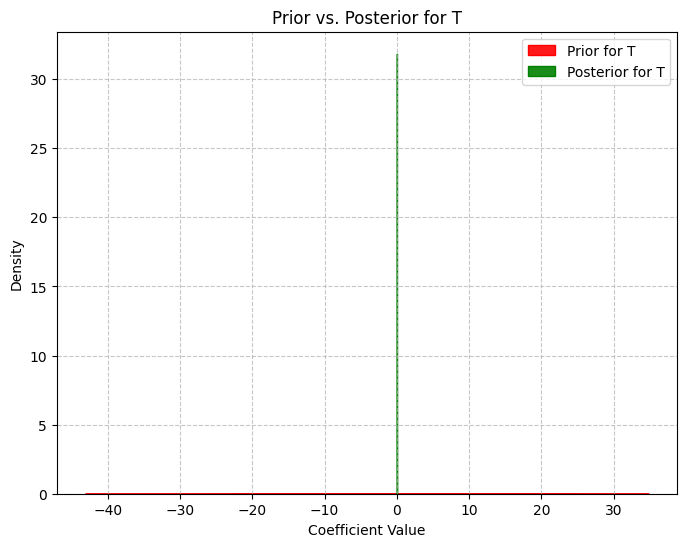

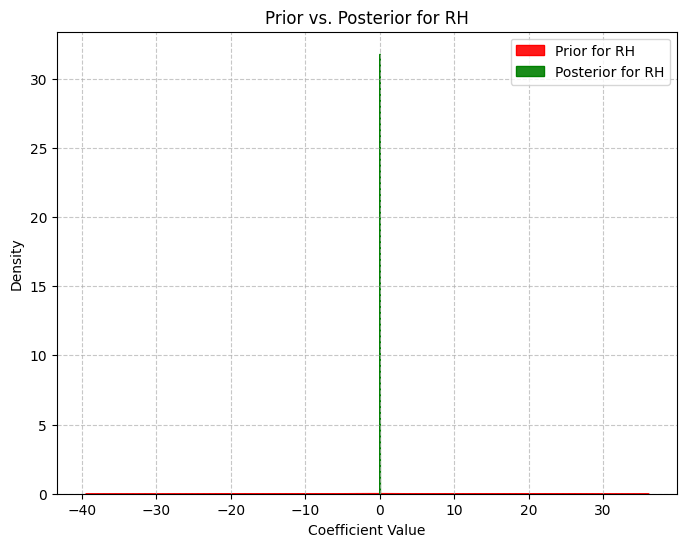

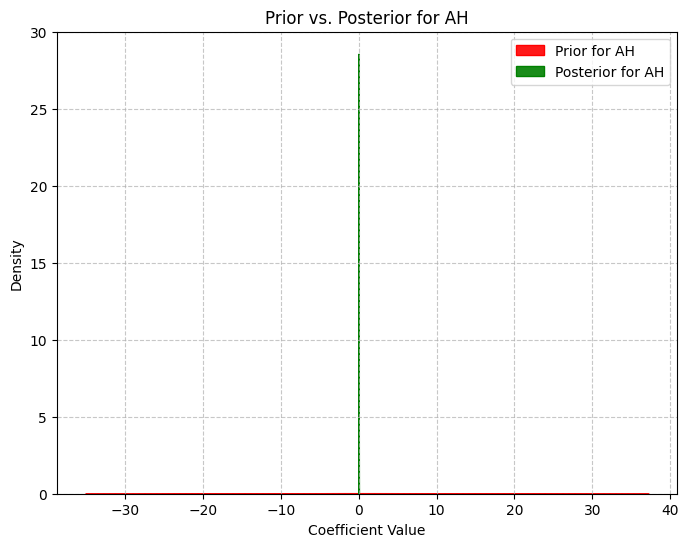

In [69]:
for i, predictor_name in enumerate(predictor_variables):
    # for posterior_gamma_beta in posterior_gamma_beta_values:
    # Extract prior and posterior for each predictor
    prior_samples = linear_prior_beta_values[:, i]
    posterior_samples = linear_trace.posterior["beta"].sel(beta_dim_0=i).values.flatten()

    # Plot prior vs. posterior
    plt.figure(figsize=(8, 6))#(8, 6)
    # plt.hist(prior_samples, bins=100, density=True, alpha=0.5, label=f"Prior for {predictor_name}")
    # plt.hist(posterior_samples, bins=100, density=True, alpha=0.5, label=f"Posterior for {predictor_name}")
    sns.kdeplot(prior_samples, fill=True, color="red", alpha=0.9, label=f"Prior for {predictor_name}")
    sns.kdeplot(posterior_samples, fill=True, color="green", alpha=0.9, label=f"Posterior for {predictor_name}")
    plt.title(f"Prior vs. Posterior for {predictor_name}")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()


Linear Model (Bayesian) Evaluation

In [70]:
with linear_model:
    # log_likelihood_gamma = 
    pm.compute_log_likelihood(linear_trace)

Output()

In [71]:
# Compute WAIC and LOO for Model Comparison
try:
    # Compute WAIC
    waic = az.waic(linear_trace)
    print(f"WAIC: {waic}")

    # Compute LOO
    gamma_loo = az.loo(linear_trace)
    print(f"LOO: {loo}")

except Exception as e:
    print("Error in computing WAIC/LOO:", str(e))

WAIC: Computed from 1500 posterior samples and 827 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  2258.62    38.83
p_waic       29.58        -

There has been a warning during the calculation. Please check the results.
Error in computing WAIC/LOO: name 'loo' is not defined


Model Comparison

In [72]:
df_comp_loo_stduent_t_gamma_linear = az.compare({"Student-t": trace_student_t, "Gamma": idata, "Linear Model (Bayesian)": linear_trace})
df_comp_loo_stduent_t_gamma_linear

rank     elpd_loo      p_loo    elpd_diff    weight  \
Linear Model (Bayesian)     0  2259.135743  29.069160     0.000000  0.954268   
Gamma                       1  1697.308942  27.420397   561.826801  0.045733   
Student-t                   2  -780.704295   0.191417  3039.840038  0.000000   

                                se        dse  warning scale  
Linear Model (Bayesian)  38.592886   0.000000     True   log  
Gamma                    64.884162  70.598667     True   log  
Student-t                 0.215572  38.471230    False   log

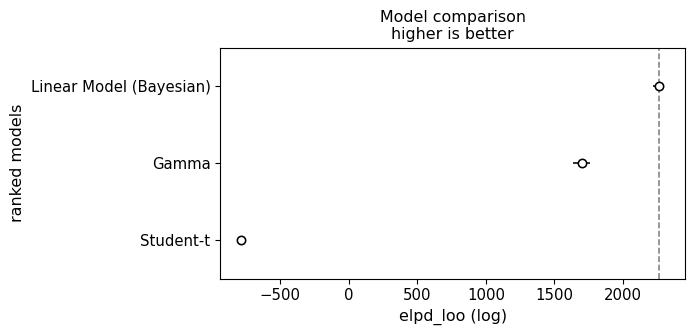

In [73]:
az.plot_compare(df_comp_loo_stduent_t_gamma_linear, insample_dev=False);